In [2]:
from qcportal import PortalClient
from openff.toolkit.topology import Molecule
from chargecraft.storage.qcarchive_transfer import QCArchiveToLocalDB
import numpy as np
import matplotlib.pyplot as plt
from chargecraft.storage.storage import MoleculePropStore, MoleculePropRecord
import pandas as pd
import seaborn as sns
import io 
from sklearn.metrics import mean_squared_error
from ast import literal_eval
import json
import ast
from rdkit import Chem
from rdkit.Chem import Draw



The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


In [3]:
DATASET_NAME = "ESP 50k opt Iodines"

client = PortalClient(address="http://10.64.1.130:7778")

dataset = client.get_dataset(dataset_type="singlepoint", dataset_name=DATASET_NAME)


add_data = []
for spec in dataset.specification_names:
    for index, _, record in dataset.iterate_records(specification_names=spec, status="complete"):
        record_data = {
            "specification": spec,
            "molecule": index,
            "tagged_smiles":Molecule.from_qcschema(record.molecule).to_smiles(mapped = True),
            "basis": record.specification.basis,
            "method": record.specification.method,
            "conformer_geom" : Molecule.from_qcschema(record.molecule).conformers[0].m,
            "dipole": record.properties["scf dipole"],
            "charges": record.properties["mbis charges"],
            "mbis dipoles": record.properties["mbis dipoles"],
            "mbis quadrupoles": record.properties["mbis quadrupoles"],
            "wall time": record.provenance.wall_time
        }
        add_data.append(record_data)

df = pd.DataFrame(add_data)
df.to_csv("benchmark_data.csv")
df

,specification,molecule,tagged_smiles,basis,method,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,wall time
0,B3LYP-def2-tzvpp-ddx-4 COSMO,Brc1ccccc1,[c:1]1([H:8])[c:2]([H:9])[c:3]([H:10])[c:4]([B...,def2-tzvpp,b3lyp,"[[-1.4554294283684233, -0.07748397421261988, -...","[-0.6944060501369904, -0.03696026915674544, -0...","[-0.13301112864852258, -0.11664526957273408, -...","[0.028814909847833414, 0.0015035282804174348, ...","[-4.539757213205152, 0.006547290745158622, -0....",53.612614
1,B3LYP-def2-tzvpp-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvpp,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-0.25827809325913165, -0.056787114714757544, ...","[0.040530467393377234, -2.987174522055977e-05,...","[-4.8205439908650725, 0.012433316162253015, -0...",41.187149
2,B3LYP-def2-tzvpp-ddx-4 COSMO,c1ccccc1,[c:1]1([H:7])[c:2]([H:8])[c:3]([H:9])[c:4]([H:...,def2-tzvpp,b3lyp,"[[-1.2161890338533092, 0.6579262961692687, -0....","[-3.8338277943777976e-05, 4.27699801417436e-05...","[-0.12516266193338935, -0.12524781154500864, -...","[0.028565998419679467, -0.015476512827540579, ...","[-4.5603520773509265, -0.05752884889337008, -0...",29.167643
3,B3LYP-def2-tzvpp-ddx-4 COSMO,C1CCNC1,[C:1]1([H:6])([H:7])[C:2]([H:8])([H:9])[C:3]([...,def2-tzvpp,b3lyp,"[[0.17920492040989322, -1.2075743017523302, -0...","[-0.03849316642676026, 0.057787212422743206, 0...","[-0.21435845314470744, -0.2144790566621501, 0....","[0.01255699677975411, 0.07769346719284626, -0....","[-4.693232093160284, -0.005153039134781002, 0....",76.742226
4,B3LYP-def2-tzvpp-ddx-4 COSMO,C1CC[NH2+]CC1,[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C:3](...,def2-tzvpp,b3lyp,"[[1.2189360585436484, 0.8347455054911456, -0.1...","[-1.299558901764033, -0.8900938090287727, 0.13...","[-0.19630093074406554, -0.2540993295122444, -0...","[-0.05290931213582083, -0.03611928313212007, -...","[-4.581856958038732, 0.0032000371480743924, -0...",105.074890
...,...,...,...,...,...,...,...,...,...,...,...
1423,HF-6-311G*-ddx-4 COSMO,N#Cc1ccccc1,[c:1]1([H:9])[c:2]([H:10])[c:3]([H:11])[c:4]([...,6-311g*,hf,"[[-1.633092597993143, 0.031578847905318286, -0...","[-1.817125525188196, 0.03512899161654248, -0.5...","[-0.09571824657158479, -0.1591725464239093, -0...","[0.01505349784901121, -0.0003109463716128329, ...","[-4.509620500506032, 0.011781319016970283, -0....",23.020976
1424,HF-6-311G*-ddx-4 COSMO,Oc1ccccc1,[c:1]1([H:8])[c:2]([H:9])[c:3]([H:10])[c:4]([O...,6-311g*,hf,"[[1.6497672885793597, -0.1711348839594382, 0.0...","[0.08849017987062169, 0.5752415668715614, 0.04...","[-0.2476600170729379, -0.049340128455664614, -...","[-0.01108752982555038, -0.006958506941790821, ...","[-4.807183265540325, -0.013543929762773589, -0...",31.393886
1425,HF-6-311G*-ddx-4 COSMO,O=C1CCCN1,[C:1]1([H:7])([H:8])[C:2]([H:9])([H:10])[C:3](...,6-311g*,hf,"[[-0.982553393564454, -0.41076041732955887, -0...","[-1.6305239593868777, 0.26315539493413187, 0.3...","[-0.2110962454672619, -0.3917949078330045, 0.8...","[0.06431140695939788, -0.013568804375138533, 0...","[-4.713344845616261, 0.02531857531222918, -0.0...",30.512118
1426,HF-6-311G*-ddx-4 COSMO,[O-]c1ccsn1,[C:1]1([H:7])=[C:2]([H:8])[S:3][N:4]=[C:5]1[O-:6],6-311g*,hf,"[[-0.09838226317818206, -0.7134580947913648, -...","[-2.809252277928966, -1.4209752478809818, 0.07...","[-0.4069667572576686, -0.19409615523562543, -0...","[0.013010249160149936, -0.05422569111686034, -...","[-5.254779429259691, -0.024262122884656387, 0....",11.598430


In [4]:
len(df['molecule'].unique())

34

In [5]:
df['molecule'].unique()

array(['Brc1ccccc1', 'Brc1cc[nH]c1', 'c1ccccc1', 'C1CCNC1',
       'C1CC[NH2+]CC1', 'C1CCOC1', 'c1ccsc1', 'c1c[nH+]c[nH]1', 'CC',
       'Cc1c[nH]c2ccccc12', 'CC(C)F', 'CC(C)=O', 'CCO', 'CCOB(O)O',
       'CC(=O)[O-]', 'CC(=O)O', 'CCS', 'CCSC', 'Clc1ccccc1', 'Clc1cccnc1',
       'COC', 'COC[B-](F)(F)F', 'COCC(F)(F)F', 'CO[Si](C)(C)O',
       'C[Si]1(C)CCCC1', 'CS(=O)(=O)[O-]', 'Fc1ccccc1', 'Fc1cccc(F)c1F',
       'Nc1ccccc1', 'N#Cc1ccccc1', 'Oc1ccccc1', 'O=C1CCCN1',
       '[O-]c1ccsn1', '[S-]c1ccccc1'], dtype=object)

In [6]:
benchdb = MoleculePropStore('/mnt/nfs/home/nca121/benchmark_db/rerun_for_paper_3/database copy.db')
benchdb.list()

['CC(C)F',
 '[O-]c1ccsn1',
 'Clc1cccnc1',
 'Brc1cc[nH]c1',
 'COCC(F)(F)F',
 'CCOB(O)O',
 'O=C1CCCN1',
 'Fc1ccccc1',
 'CC(=O)O',
 'COC',
 'CCO',
 'CC(C)=O',
 'CC(=O)[O-]',
 'Clc1ccccc1',
 'c1c[nH+]c[nH]1',
 'C1CCNC1']

In [7]:
benchdb.retrieve('CC')

[]

In [8]:
# prop_store = MoleculePropStore('/mnt/storage/nobackup/nca121/QC_archive_review/benchmark_review/benchmark.db')
prop_store = benchdb
smiles_list = df['molecule'].unique()
add_data = []
for mol in smiles_list:
    print(mol)
    try:
        item =  prop_store.retrieve(smiles=mol,method='ccsd',basis='aug-cc-pvtz')
        record_data = {
                "specification": 'ccsd-aug-cc-pVTZP',
                "molecule": mol,
                "tagged_smiles":item[0].tagged_smiles,
                "basis": 'aug-cc-pVTZP',
                "conformer_geom": item[0].conformer,
                "dipole": item[0].dipole,
                "charges": item[0].mbis_charges.flatten(),
                "mbis dipoles": item[0].mbis_dipole.flatten(),
                "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                "esp": item[0].esp_quantity,
                "grid": item[0].grid_coordinates_quantity,
            }
        add_data.append(record_data)
    except IndexError:
        continue
df_ccsd = pd.DataFrame(add_data)

df = pd.concat([df,df_ccsd], axis=0)


Brc1ccccc1
Brc1cc[nH]c1
c1ccccc1
C1CCNC1
C1CC[NH2+]CC1
C1CCOC1
c1ccsc1
c1c[nH+]c[nH]1
CC
Cc1c[nH]c2ccccc12
CC(C)F
CC(C)=O
CCO
CCOB(O)O
CC(=O)[O-]
CC(=O)O
CCS
CCSC
Clc1ccccc1
Clc1cccnc1
COC
COC[B-](F)(F)F
COCC(F)(F)F
CO[Si](C)(C)O
C[Si]1(C)CCCC1
CS(=O)(=O)[O-]
Fc1ccccc1
Fc1cccc(F)c1F
Nc1ccccc1
N#Cc1ccccc1
Oc1ccccc1
O=C1CCCN1
[O-]c1ccsn1
[S-]c1ccccc1


In [9]:
df[df['molecule'] == 'Brc1cc[nH]c1']

,specification,molecule,tagged_smiles,basis,method,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,wall time,esp,grid
1,B3LYP-def2-tzvpp-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvpp,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-0.25827809325913165, -0.056787114714757544, ...","[0.040530467393377234, -2.987174522055977e-05,...","[-4.8205439908650725, 0.012433316162253015, -0...",41.187149,NaN,NaN
35,B3LYP-def2-tzvpd-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvpd,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.24649691118924, -0.4906426545635796, -0.13...","[-0.2578522365806676, -0.057113602714217934, -...","[0.03986754055610189, -0.004272962030433441, 0...","[-4.824186247448815, 0.01531323519082067, -0.0...",52.156195,NaN,NaN
69,B3LYP-def2-tzvp-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvp,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2706383862526422, -0.5051492461239029, -0....","[-0.26136243513826357, -0.060489552455425956, ...","[0.04074302739806772, -0.0001389173437196886, ...","[-4.8291691615798245, 0.013348531234931628, -0...",41.459330,NaN,NaN
103,B3LYP-def2-svpd-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-svpd,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2603348337478621, -0.4971843054870426, -0....","[-0.24992836436246707, -0.03223570473243371, -...","[0.04354087826444401, 0.006420654144094134, 0....","[-4.813906891246667, 0.018542760972589698, -0....",38.337425,NaN,NaN
137,B3LYP-def2-tzvppd-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvppd,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2461721466539757, -0.4900746361492061, -0....","[-0.2557683121122133, -0.05576020114655759, -0...","[0.040351756286848645, -0.0032730154087861297,...","[-4.817120550764345, 0.015285919306821178, -0....",58.671229,NaN,NaN
171,B3LYP-6-31G*-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,6-31g*,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.3118822892410549, -0.5110151770381801, -0....","[-0.2482689641540761, -0.034626250125769045, -...","[0.04500788712881645, 0.019624020471631483, 0....","[-4.713857539617136, 0.010902237659234053, -0....",35.020224,NaN,NaN
205,B3LYP-6-311G*-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,6-311g*,b3lyp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2953943231918856, -0.5252076718872747, -0....","[-0.2718169739839899, -0.06638200574420736, -0...","[0.0393256200884422, 0.005172077405088979, 0.0...","[-4.826119708686556, 0.012423878459025175, -0....",33.491380,NaN,NaN
239,PBE0-def2-tzvpp-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvpp,pbe0,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2779162851300043, -0.5057411092996826, -0....","[-0.265974749775566, -0.060898556551331515, -0...","[0.04291483825268887, 0.0009141718882429657, 0...","[-4.848247082351148, 0.012963447726378877, -0....",45.756075,NaN,NaN
273,PBE0-def2-tzvpd-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvpd,pbe0,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2628415957387347, -0.49580112914137686, -0...","[-0.2658028965175176, -0.061371706205520446, -...","[0.04230633678957058, -0.003320390323385493, 0...","[-4.852817563435315, 0.01605486113319661, -0.0...",50.456683,NaN,NaN
307,PBE0-def2-tzvp-ddx-4 COSMO,Brc1cc[nH]c1,[C:1]1([H:7])=[C:2]([H:8])[N:3]([H:9])[C:4]([H...,def2-tzvp,pbe0,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2867691050365124, -0.5100840865625536, -0....","[-0.2688965596659453, -0.0642625300190236, -0....","[0.04320314537992276, 0.0008859171774593552, 0...","[-4.856196231614863, 0.013913748433828005, -0....",42.957

In [10]:
df[df['molecule'] == 'CC(C)=O']

,specification,molecule,tagged_smiles,basis,method,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,wall time,esp,grid
11,B3LYP-def2-tzvpp-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvpp,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.01057408897237222, -0.9628946935551319, 0.5...","[-0.6075402653293679, 0.7082852410577773, -0.5...","[-0.006835356704107865, 0.004371683762899541, ...","[-5.399961431379444, -0.01488470916789988, 0.0...",32.797194,NaN,NaN
45,B3LYP-def2-tzvpd-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvpd,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010840946986293787, -0.9871954355979646, 0....","[-0.6210922931398407, 0.7207663663151481, -0.5...","[-0.007129273559118594, 0.00337760221013639, -...","[-5.432792756489481, -0.009034369041710903, 0....",34.543203,NaN,NaN
79,B3LYP-def2-tzvp-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvp,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010566940447557238, -0.9622314524019338, 0....","[-0.6134630378775574, 0.7109759432134968, -0.5...","[-0.004532076846463065, 0.004810827971675393, ...","[-5.413975845226479, -0.018881297708959605, 0....",29.033240,NaN,NaN
113,B3LYP-def2-svpd-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-svpd,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.011034151522416824, -1.0047989534780122, 0....","[-0.5755471354207542, 0.7033782502521574, -0.5...","[-0.011566064288028106, -0.0013662577216643564...","[-5.324871348429327, -0.01448697790741376, 0.0...",27.625716,NaN,NaN
147,B3LYP-def2-tzvppd-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvppd,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010841819249448381, -0.9872782795705568, 0....","[-0.6156889032962352, 0.7179892993881022, -0.5...","[-0.007556180588293454, 0.003212538607760985, ...","[-5.42060037092187, -0.010238852273382134, 0.0...",40.536048,NaN,NaN
181,B3LYP-6-31G*-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,6-31g*,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.009886442411404683, -0.9003094429459892, 0....","[-0.5377041144918067, 0.6318347812229239, -0.4...","[-0.008088776982021583, 0.0022753913110243433,...","[-5.153611436867311, -0.029838505983299964, 0....",21.332624,NaN,NaN
215,B3LYP-6-311G*-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,6-311g*,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010019690632135314, -0.9124266509691914, 0....","[-0.6245938294693781, 0.6876436350931053, -0.4...","[0.008655308816962316, 0.005326530533136266, -...","[-5.440614679538401, -0.029922871414638383, 0....",23.910566,NaN,NaN
249,PBE0-def2-tzvpp-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvpp,pbe0,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010583617680059998, -0.9637963737868596, 0....","[-0.6468309956744426, 0.6997760570627674, -0.5...","[-0.00656998379408677, 0.006687094011268192, -...","[-5.4655997364308, -0.014382242910125695, 0.02...",30.192521,NaN,NaN
283,PBE0-def2-tzvpd-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvpd,pbe0,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010827192656779783, -0.9859746036945403, 0....","[-0.6588934690622215, 0.7109221400364794, -0.5...","[-0.006969667940824701, 0.005743238070978864, ...","[-5.494734263649805, -0.008323894999369153, 0....",33.140570,NaN,NaN
317,PBE0-def2-tzvp-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvp,pbe0,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010580459449246904, -0.9634964352224777, 0....","[-0.6520369332056374, 0.7020306791842466, -0.5...","[-0.004458128687977062, 0.007100346465099187, ...","[-5.477203620441571, -0.018242747270956254, 0....",28.741842,NaN,NaN


In [11]:
df[df['molecule'] == 'CC(C)=O']

,specification,molecule,tagged_smiles,basis,method,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,wall time,esp,grid
11,B3LYP-def2-tzvpp-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvpp,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.01057408897237222, -0.9628946935551319, 0.5...","[-0.6075402653293679, 0.7082852410577773, -0.5...","[-0.006835356704107865, 0.004371683762899541, ...","[-5.399961431379444, -0.01488470916789988, 0.0...",32.797194,NaN,NaN
45,B3LYP-def2-tzvpd-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvpd,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010840946986293787, -0.9871954355979646, 0....","[-0.6210922931398407, 0.7207663663151481, -0.5...","[-0.007129273559118594, 0.00337760221013639, -...","[-5.432792756489481, -0.009034369041710903, 0....",34.543203,NaN,NaN
79,B3LYP-def2-tzvp-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvp,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010566940447557238, -0.9622314524019338, 0....","[-0.6134630378775574, 0.7109759432134968, -0.5...","[-0.004532076846463065, 0.004810827971675393, ...","[-5.413975845226479, -0.018881297708959605, 0....",29.033240,NaN,NaN
113,B3LYP-def2-svpd-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-svpd,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.011034151522416824, -1.0047989534780122, 0....","[-0.5755471354207542, 0.7033782502521574, -0.5...","[-0.011566064288028106, -0.0013662577216643564...","[-5.324871348429327, -0.01448697790741376, 0.0...",27.625716,NaN,NaN
147,B3LYP-def2-tzvppd-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvppd,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010841819249448381, -0.9872782795705568, 0....","[-0.6156889032962352, 0.7179892993881022, -0.5...","[-0.007556180588293454, 0.003212538607760985, ...","[-5.42060037092187, -0.010238852273382134, 0.0...",40.536048,NaN,NaN
181,B3LYP-6-31G*-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,6-31g*,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.009886442411404683, -0.9003094429459892, 0....","[-0.5377041144918067, 0.6318347812229239, -0.4...","[-0.008088776982021583, 0.0022753913110243433,...","[-5.153611436867311, -0.029838505983299964, 0....",21.332624,NaN,NaN
215,B3LYP-6-311G*-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,6-311g*,b3lyp,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010019690632135314, -0.9124266509691914, 0....","[-0.6245938294693781, 0.6876436350931053, -0.4...","[0.008655308816962316, 0.005326530533136266, -...","[-5.440614679538401, -0.029922871414638383, 0....",23.910566,NaN,NaN
249,PBE0-def2-tzvpp-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvpp,pbe0,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010583617680059998, -0.9637963737868596, 0....","[-0.6468309956744426, 0.6997760570627674, -0.5...","[-0.00656998379408677, 0.006687094011268192, -...","[-5.4655997364308, -0.014382242910125695, 0.02...",30.192521,NaN,NaN
283,PBE0-def2-tzvpd-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvpd,pbe0,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010827192656779783, -0.9859746036945403, 0....","[-0.6588934690622215, 0.7109221400364794, -0.5...","[-0.006969667940824701, 0.005743238070978864, ...","[-5.494734263649805, -0.008323894999369153, 0....",33.140570,NaN,NaN
317,PBE0-def2-tzvp-ddx-4 COSMO,CC(C)=O,[C:1]([C:2](=[O:3])[C:4]([H:8])([H:9])[H:10])(...,def2-tzvp,pbe0,"[[-1.2682093729697743, -0.03231651414779633, 0...","[0.010580459449246904, -0.9634964352224777, 0....","[-0.6520369332056374, 0.7020306791842466, -0.5...","[-0.004458128687977062, 0.007100346465099187, ...","[-5.477203620441571, -0.018242747270956254, 0....",28.741842,NaN,NaN


In [12]:
import pandas as pd
import pickle

# Assuming you have already read your CSV into a DataFrame 'df' with the correct data types.
# If not, read the CSV file first (make sure to include any necessary converters).

# Example: Reading the CSV file (modify converters if necessary)
# df = pd.read_csv('yourfile.csv', converters=converters)

# Ensure that 'molecule' and 'conformer_geom' columns are present
if 'molecule' not in df.columns or 'conformer_geom' not in df.columns:
    raise ValueError("DataFrame must contain 'molecule' and 'conformer_geom' columns.")

# Drop any rows where 'molecule' or 'conformer_geom' is missing
df = df.dropna(subset=['molecule', 'conformer_geom'])

# Initialize an empty dictionary to hold the SMILES and their conformers
smiles_conformers_dict = {}

# Group the DataFrame by the 'molecule' column to get unique SMILES
grouped = df.groupby('molecule')

# Iterate over each unique SMILES and collect associated conformer geometries
for smiles, group in grouped:
    # Extract the list of conformer geometries for this SMILES
    conformer_geoms = group['conformer_geom'].tolist()
    # Store the SMILES and its conformer geometries in the dictionary
    smiles_conformers_dict[smiles] = conformer_geoms

# Define the output file path for the pickle file
output_file = 'smiles_conformers.pkl'

# Save the dictionary to a pickle file
with open(output_file, 'wb') as f:
    pickle.dump(smiles_conformers_dict, f)

print(f"Dictionary of SMILES and conformer geometries has been saved to '{output_file}'.")


Dictionary of SMILES and conformer geometries has been saved to 'smiles_conformers.pkl'.


In [13]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='dipole',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-1.2953943231918856, -0.5252076718872747, -0....","[-1.3118822892410549, -0.5110151770381801, -0....","[-1.2603348337478621, -0.4971843054870426, -0....","[-1.2706383862526422, -0.5051492461239029, -0....","[-1.24649691118924, -0.4906426545635796, -0.13...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-1.2461721466539757, -0.4900746361492061, -0....","[-1.3886944899277864, -0.5438494968748309, -0....","[-1.3983428621718588, -0.5243996013981249, -0....",...,"[-1.2739920154524498, -0.5108837101104502, -0....","[-1.260337842416618, -0.5004050087313505, -0.1...","[-1.313044223743077, -0.5348799317732471, -0.1...","[-1.325433384466919, -0.518971197646783, -0.14...","[-1.2913230936453601, -0.5080369146707948, -0....","[-1.296100343016576, -0.5171397170871401, -0.1...","[-1.271358677022647, -0.5038106483895959, -0.1...","[-1.2866187386722174, -0.5117436542837766, -0....","[-1.270006860333325, -0.5022571140716092, -0.1...","[-1.2333162800917705, -0.4930380861029402, -0...."
1,Brc1ccccc1,"[-0.7070148411128798, -0.037632012198887566, -...","[-0.7504798607498628, -0.03994425563852033, -0...","[-0.7019719494553271, -0.037361270264899105, -...","[-0.6987129182177512, -0.0371895897292962, -0....","[-0.6965723194471138, -0.037075359365035254, -...","[-0.6944060501369904, -0.03696026915674544, -0...","[-0.6968127625872853, -0.03708809158927373, -0...","[-0.8172765019907899, -0.04349179361430444, -0...","[-0.8596626760912045, -0.04574684031043752, -0...",...,"[-0.705223227594928, -0.03753125985587502, -0....","[-0.7090718255441857, -0.03773500922595119, -0...","[-0.7238867832255096, -0.038527590816094914, -...","[-0.7640135025320376, -0.04066250985915154, -0...","[-0.732919402610662, -0.0390041489275017, -0.0...","[-0.7204711400198107, -0.03834256835436811, -0...","[-0.7150087787327948, -0.03805095469581943, -0...","[-0.7173478152137136, -0.03817617527982087, -0...","[-0.7156239288629251, -0.0380836004278482, -0....",NaN
2,C1CCNC1,"[-0.05340733622930216, 0.07182754499833566, 0....","[-0.040306160275938474, 0.05983945598220153, 0...","[-0.03508005739546949, 0.056428395755045546, 0...","[-0.03906031082588246, 0.058699069660290704, 0...","[-0.03219053856960663, 0.05356931587712177, 0....","[-0.03849316642676026, 0.057787212422743206, 0...","[-0.032267689292735824, 0.05361065450987068, 0...","[-0.03622914786590847, 0.060269069645700224, 0...","[-0.023416313261286348, 0.04944599764160662, 0...",...,"[-0.03768384362811794, 0.05807079435683127, 0....","[-0.03208273488453983, 0.05450675795946358, 0....","[-0.04850822903431773, 0.06908904968048724, 0....","[-0.034715001411026236, 0.05666578367788455, 0...","[-0.03050763573996562, 0.053861670084889735, 0...","[-0.03754108083918162, 0.05882203199288005, 0....","[-0.03208415238814499, 0.0547786966800925, 0.3...","[-0.0355803450061245, 0.05665928398685738, 0.3...","[-0.031276171104672734, 0.05406370288403339, 0...","[-0.026712145542145294, 0.05056951378575869, 0..."
3,C1CCOC1,"[-0.5432887901474004, 0.3476876857324278, -0.1...","[-0.5354847203230602, 0.3426869544644493, -0.1...","[-0.5656917949597151, 0.36203375817628647, -0....","[-0.5413539051448968, 0.3464536559728657, -0.1...","[-0.5470675531582252, 0.35011504926654524, -0....","[-0.5378627330490886, 0.34422068017565977, -0....","[-0.5468231945293454, 0.3499589508983316, -0.1...","[-0.6050645442135583, 0.38722348449260124, -0....","[-0.6089516191497442, 0.38970623134099647, -

In [14]:
ccsd_only_df = pivot_df[pivot_df['ccsd-aug-cc-pVTZP'].notnull()]
ccsd_only_df

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-1.2953943231918856, -0.5252076718872747, -0....","[-1.3118822892410549, -0.5110151770381801, -0....","[-1.2603348337478621, -0.4971843054870426, -0....","[-1.2706383862526422, -0.5051492461239029, -0....","[-1.24649691118924, -0.4906426545635796, -0.13...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-1.2461721466539757, -0.4900746361492061, -0....","[-1.3886944899277864, -0.5438494968748309, -0....","[-1.3983428621718588, -0.5243996013981249, -0....",...,"[-1.2739920154524498, -0.5108837101104502, -0....","[-1.260337842416618, -0.5004050087313505, -0.1...","[-1.313044223743077, -0.5348799317732471, -0.1...","[-1.325433384466919, -0.518971197646783, -0.14...","[-1.2913230936453601, -0.5080369146707948, -0....","[-1.296100343016576, -0.5171397170871401, -0.1...","[-1.271358677022647, -0.5038106483895959, -0.1...","[-1.2866187386722174, -0.5117436542837766, -0....","[-1.270006860333325, -0.5022571140716092, -0.1...","[-1.2333162800917705, -0.4930380861029402, -0...."
2,C1CCNC1,"[-0.05340733622930216, 0.07182754499833566, 0....","[-0.040306160275938474, 0.05983945598220153, 0...","[-0.03508005739546949, 0.056428395755045546, 0...","[-0.03906031082588246, 0.058699069660290704, 0...","[-0.03219053856960663, 0.05356931587712177, 0....","[-0.03849316642676026, 0.057787212422743206, 0...","[-0.032267689292735824, 0.05361065450987068, 0...","[-0.03622914786590847, 0.060269069645700224, 0...","[-0.023416313261286348, 0.04944599764160662, 0...",...,"[-0.03768384362811794, 0.05807079435683127, 0....","[-0.03208273488453983, 0.05450675795946358, 0....","[-0.04850822903431773, 0.06908904968048724, 0....","[-0.034715001411026236, 0.05666578367788455, 0...","[-0.03050763573996562, 0.053861670084889735, 0...","[-0.03754108083918162, 0.05882203199288005, 0....","[-0.03208415238814499, 0.0547786966800925, 0.3...","[-0.0355803450061245, 0.05665928398685738, 0.3...","[-0.031276171104672734, 0.05406370288403339, 0...","[-0.026712145542145294, 0.05056951378575869, 0..."
6,CC(=O)O,"[-0.0876510201192282, -0.5970085703818455, 0.0...","[-0.09832699131881739, -0.6112030540777074, 0....","[-0.1858911079770742, -0.6702165222078147, 0.0...","[-0.1566696689185001, -0.65460672093187, 0.071...","[-0.19351863133005764, -0.6652481754690349, 0....","[-0.16679785314656925, -0.6595741918718012, 0....","[-0.1929208591685594, -0.6655390066106914, 0.0...","[-0.16794463013686212, -0.6645774601600944, 0....","[-0.1816933197075734, -0.6747276651778282, 0.0...",...,"[-0.1670640559085541, -0.6596594455243956, 0.0...","[-0.19239251299841698, -0.6671068164806027, 0....","[-0.09412967130993621, -0.6114940260511226, 0....","[-0.10642808019632355, -0.6253034593532742, 0....","[-0.18851756145672738, -0.6810232296252057, 0....","[-0.15311838298188363, -0.6649392249892134, 0....","[-0.18415712134863682, -0.6743270128660122, 0....","[-0.16662568637108066, -0.670573041559047, 0.0...","[-0.18603123900587093, -0.6745393571762417, 0....","[-0.18978360109818126, -0.6322562103931855, 0...."
7,CC(=O)[O-],"[-2.466353531513519, -0.021557005329044365, -0...","[-2.5087822628236722, -0.020566037513067847, -...","[-2.7000712681423025, -0.03419309118698133, -0...","[-2.6024197621971084, -0.028860587482318678, -...","[-2.6548755155612582, -0.034869183493859035, -...","[-2.5959522739222933, -0.028440810401981376, -...","[-2.6528066503963075, -0.034553596686077825, -...","[-2.752227247108898, -0.03157096944309057, -0...

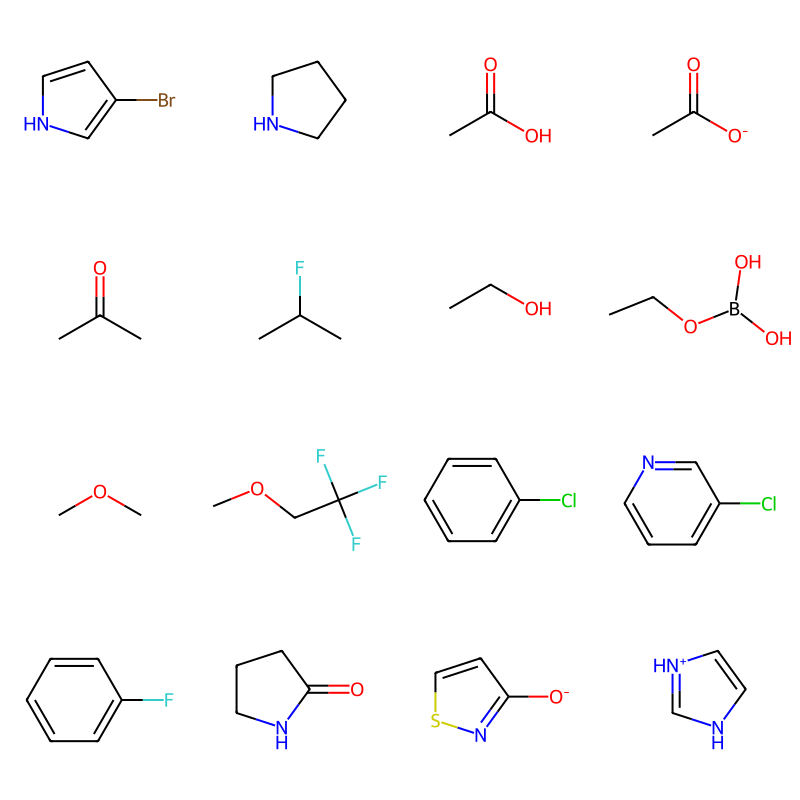

In [15]:
molecules_benchmarked = []
for smiles in ccsd_only_df['molecule'].tolist():
    rdkit_mol =  Chem.MolFromSmiles(smiles)
    molecules_benchmarked.append(rdkit_mol)
    
Draw.MolsToGridImage(molecules_benchmarked, molsPerRow=4)
    

In [16]:
def normalize_dipole(dipole_vector):
    if isinstance(dipole_vector, np.ndarray):  # Check if the value is a list
        return np.linalg.norm(dipole_vector)
    else:
        return None  # Return None or some other flag value for non-list data

#Step 0: fix column names
pivot_df.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df.columns]

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
# columns_to_plot = [col for col in pivot_df.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot = list(pivot_df.columns)
columns_to_plot.remove('molecule')
columns_to_plot.append('HF-6-31G*')

remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

pivot_df[columns_to_plot].applymap(normalize_dipole)

# The target column for comparison
target_column = 'ccsd-aug-cc-pVTZP'

rmse_dipoles = []

# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
for col in columns_to_plot:
    # plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    clean_df = pivot_df[[target_column, col]].dropna()
    pivot_df_filter = pivot_df.filter(items = [target_column, col])
    col_x = target_column
    x_tot = []
    y_tot = []
    total_skipped = 0

    for index, row in pivot_df_filter.iterrows():
        x_values = row[col_x]
        if isinstance(x_values, np.ndarray):
            # Loop through each specified y-column
            # for col_y, color in col_to_color.items():
            # y_values = ast.literal_eval(row[col])
            y_values = row[col]

            if mean_squared_error(y_values, x_values) >0.15:
                total_skipped += 1
                print(f'num molecules skipped {total_skipped} for {col}')
                # print(f"excluding molecule {pivot_df.iloc[index]['molecule']}")
                continue
            x_tot.extend(x_values)
            y_tot.extend(y_values)

    if len(x_tot) == 0 or len(y_tot) == 0:
        continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    information = {"rmse": rmse,
                   "spec": col }
    rmse_dipoles.append(information)
rmse_dipoles = pd.DataFrame(rmse_dipoles)

ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz


/scratch/ipykernel_14772/195945910.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_df[columns_to_plot].applymap(normalize_dipole)


In [17]:
rmse_dipoles

,rmse,spec
0,0.053381,B3LYP-6-311G*
1,0.056356,B3LYP-6-31G*
2,0.016848,B3LYP-def2-svpd
3,0.026322,B3LYP-def2-tzvp
4,0.016445,B3LYP-def2-tzvpd
5,0.027285,B3LYP-def2-tzvpp
6,0.016590,B3LYP-def2-tzvppd
7,0.075741,HF-6-311G*
8,0.069049,HF-6-31G*
9,0.074931,HF-def2-svpd


In [36]:
rmse_dipoles.spec.unique()

array(['B3LYP-6-311G*', 'B3LYP-6-31G*', 'B3LYP-def2-svpd',
       'B3LYP-def2-tzvp', 'B3LYP-def2-tzvpd', 'B3LYP-def2-tzvpp',
       'B3LYP-def2-tzvppd', 'HF-6-311G*', 'HF-6-31G*', 'HF-def2-svpd',
       'HF-def2-tzvp', 'HF-def2-tzvpd', 'HF-def2-tzvpp', 'HF-def2-tzvppd',
       'PBE0-6-311G*', 'PBE0-6-31G*', 'PBE0-def2-svpd', 'PBE0-def2-tzvp',
       'PBE0-def2-tzvpd', 'PBE0-def2-tzvpp', 'PBE0-def2-tzvppd',
       'TPSSH-6-311G*', 'TPSSH-6-31G*', 'TPSSH-def2-svpd',
       'TPSSH-def2-tzvp', 'TPSSH-def2-tzvpd', 'TPSSH-def2-tzvpp',
       'TPSSH-def2-tzvppd', 'WB97M-D3BJ-6-311G*', 'WB97M-D3BJ-6-31G*',
       'WB97M-D3BJ-def2-svpd', 'WB97M-D3BJ-def2-tzvp',
       'WB97M-D3BJ-def2-tzvpd', 'WB97M-D3BJ-def2-tzvpp',
       'WB97M-D3BJ-def2-tzvppd', 'WB97X-D-6-311G*', 'WB97X-D-6-31G*',
       'WB97X-D-def2-svpd', 'WB97X-D-def2-tzvp', 'WB97X-D-def2-tzvpd',
       'WB97X-D-def2-tzvpp', 'WB97X-D-def2-tzvppd', 'ccsd-aug-cc-pVTZP'],
      dtype=object)

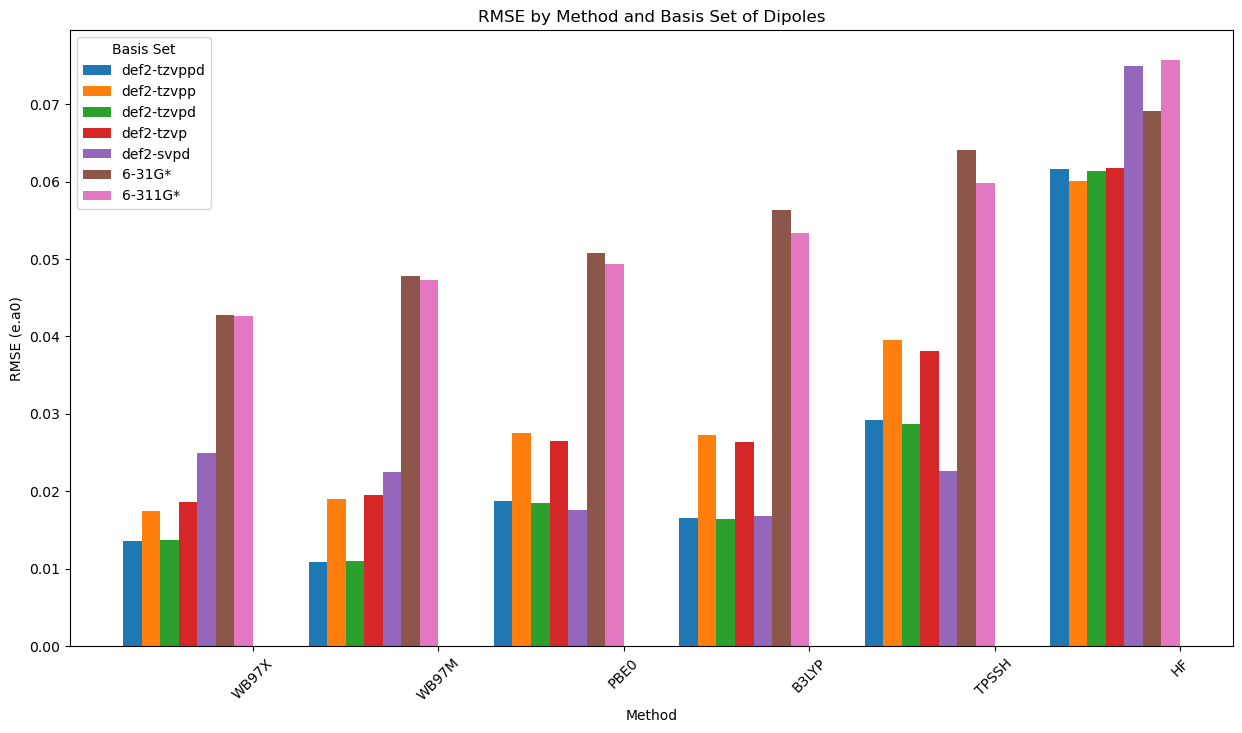

In [45]:
# Create a DataFrame from the list
df_rmse = rmse_dipoles

# Extract method and basis from the 'spec' key
df_rmse['method'] = df_rmse['spec'].apply(lambda x: x.split('-')[0].upper())  # Convert method to uppercase for consistency
df_rmse['basis'] = df_rmse['spec'].apply(lambda x: '-'.join(x.split('-')[-2:]))

# Calculate average RMSE for each method to determine the order
average_rmse_by_method = df_rmse.groupby('method')['rmse'].mean().sort_values()

# Sort the dataframe by the average RMSE of each method
df_rmse['method_avg_rmse'] = df_rmse['method'].map(average_rmse_by_method)
df_rmse_sorted = df_rmse.sort_values(by=['method_avg_rmse', 'method', 'basis'])
df_rmse_sorted.drop('method_avg_rmse', axis=1, inplace=True)
# Use a categorical type to ensure the methods are plotted in the sorted order
df_rmse_sorted['method'] = pd.Categorical(df_rmse_sorted['method'], categories=average_rmse_by_method.index, ordered=True)

# Normalize basis set labels
df_rmse_sorted['basis'] = df_rmse_sorted['basis'].replace({
    'cc-pVTZ': 'cc-pvtz',
    'gas-tzvp': 'def2-tzvp',
    'gas-tzvppd': 'def2-tzvppd'
})


# Creating a color map
unique_basis = df_rmse_sorted['basis'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_basis)))
color_map = dict(zip(unique_basis, colors))

desired_order = [
    'def2-tzvppd','def2-tzvpp','def2-tzvpd', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'
]

df_rmse_sorted['basis'] = pd.Categorical(
    df_rmse_sorted['basis'],
    categories=desired_order,
    ordered=True
)


# Creating the pivot table
pivot_table = df_rmse_sorted.pivot_table(index='method', columns='basis', values='rmse', aggfunc = 'mean')
pivot_table_plot = pivot_table.drop(index='CCSD', errors='ignore')

fig, ax = plt.subplots(figsize=(15, 8))
bar_width = 0.1  # Adjust as necessary for the number of basis sets

# Determine the maximum number of non-NaN entries in a row (group)
group_width = np.max([np.sum(~pivot_table_plot.loc[method].isna()) 
                       for method in pivot_table_plot.index]) * bar_width

for i, basis in enumerate(pivot_table_plot.columns):
    # For each method (row) compute the offset for the current basis bar
    offsets = np.array([
        bar_width * (i - np.sum(~pivot_table_plot.loc[method].isna()) / 2)
        for method in pivot_table_plot.index
    ])
    positions = np.arange(len(pivot_table_plot.index)) + offsets
    ax.bar(positions, pivot_table_plot[basis], width=bar_width, label=basis)

# Set the x-axis ticks and labels based on the filtered methods
ax.set_xticks(np.arange(len(pivot_table_plot)) + bar_width / 2 * (len(pivot_table_plot.columns) - 1))
ax.set_xticklabels(pivot_table_plot.index, rotation=45)

ax.set_xlabel('Method')
ax.set_ylabel('RMSE (e.a0)')
ax.set_title('RMSE by Method and Basis Set of Dipoles')
ax.legend(title='Basis Set')

plt.show()


In [20]:

df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='charges',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df
pivot_df.to_csv('charge_results.csv')

In [21]:
pivot_df

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-0.2718169739839899, -0.06638200574420736, -0...","[-0.2482689641540761, -0.034626250125769045, -...","[-0.24992836436246707, -0.03223570473243371, -...","[-0.26136243513826357, -0.060489552455425956, ...","[-0.2578522365806676, -0.057113602714217934, -...","[-0.25827809325913165, -0.056787114714757544, ...","[-0.2557683121122133, -0.05576020114655759, -0...","[-0.29280868788488296, -0.018471908992002607, ...","[-0.27782482476862236, 0.00331574554063152, -0...",...,"[-0.26887485728517757, -0.0532344370959924, -0...","[-0.2669213879316715, -0.05364807189170726, -0...","[-0.2815537973682308, -0.06571299079855751, -0...","[-0.2638008923230663, -0.041483777703687566, -...","[-0.26132066219431344, -0.032026061036999724, ...","[-0.26976011184827603, -0.057769614416716776, ...","[-0.2673324976431785, -0.055246939675787546, -...","[-0.2671358907326391, -0.05433421468582695, -0...","[-0.26537351293064254, -0.0541030341914177, -0...","[-0.2646661933457908, -0.049086306265596034, -..."
1,Brc1ccccc1,"[-0.14133832080761807, -0.12325871142526136, -...","[-0.12704985040538905, -0.11106605038094969, -...","[-0.12425994745758652, -0.10776474760087404, -...","[-0.13503707535023884, -0.11913962625509021, -...","[-0.13343465626300183, -0.11686532314252582, -...","[-0.13301112864852258, -0.11664526957273408, -...","[-0.13216093863171263, -0.11586417750566737, -...","[-0.1447943855662272, -0.12993539763109643, -0...","[-0.13493257685220886, -0.12186251166082177, -...",...,"[-0.13914253367611173, -0.12286203875434452, -...","[-0.13869439254664773, -0.1228705810014542, -0...","[-0.14892260292693155, -0.13082167620801308, -...","[-0.13884794264558634, -0.12268411516275078, -...","[-0.13315008963897979, -0.11682771992222521, -...","[-0.14201585213892762, -0.12607602599241804, -...","[-0.14122910854258122, -0.12485511837477163, -...","[-0.14036046547455888, -0.12398688877649092, -...","[-0.14013168691598743, -0.12402103847689007, -...",NaN
2,C1CCNC1,"[-0.2279938236009933, -0.22809390626310885, 0....","[-0.2129444395500667, -0.21302616185030585, 0....","[-0.2067937521928401, -0.20693149577116707, 0....","[-0.21636290254182164, -0.2164766987117448, 0....","[-0.21765815368061836, -0.21778031676147305, 0...","[-0.21435845314470744, -0.2144790566621501, 0....","[-0.21640130225011076, -0.21652989152119667, 0...","[-0.21185677229070005, -0.21194751007209334, 0...","[-0.20387090449803297, -0.20394493036572064, 0...",...,"[-0.2316225707415443, -0.23174161037979363, 0....","[-0.23516452569945723, -0.23530140679203895, 0...","[-0.24476403757928147, -0.24485724985400759, 0...","[-0.23508551825483642, -0.2351626001092943, 0....","[-0.22498251548329865, -0.22511385361923575, 0...","[-0.23501279186658414, -0.23512263074908324, 0...","[-0.23644534657992217, -0.23656524953274943, 0...","[-0.23303411345790528, -0.23314854841014213, 0...","[-0.23552205542611546, -0.23564824556948955, 0...","[-0.22799152875452647, -0.22812392019880687, 0..."
3,C1CCOC1,"[-0.2880734750415554, -0.2880917666758534, 0.1...","[-0.269985244661781, -0.26999769865655504, 0.1...","[-0.257831976327678, -0.25785262665368336, 0.1...","[-0.27201703522699194, -0.2720381481282204, 0....","[-0.2723241043398373, -0.27234325941147464, 0....","[-0.27127132244567376, -0.27129364558793057, 0...","[-0.27128934300392504, -0.2713094547416372, 0....","[-0.27494939943492386, -0.2749581695600586, 0....","[-0.2633086487464382, -0.2633130918413161, 0

In [22]:

df_wall_time = df[['specification','molecule','basis','dipole','charges','wall time']]

pivot_df_wall_time = df_wall_time.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='wall time',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()

pivot_df_wall_time


specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpd-ddx-4 COSMO,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO
0,Brc1cc[nH]c1,33.491380,35.020224,38.337425,41.459330,52.156195,41.187149,58.671229,31.085625,28.129402,...,100.598458,80.101196,83.122290,36.708118,39.354947,39.835359,45.057133,53.276009,40.499099,56.134256
1,Brc1ccccc1,38.784600,39.404968,45.363928,49.831823,85.269469,53.612614,69.930980,31.391948,30.995576,...,159.024256,129.989320,175.799496,42.795359,40.318588,48.773921,63.567480,67.553411,59.885317,110.508483
2,C1CCNC1,39.834290,34.546195,49.233741,50.536387,64.697090,76.742226,75.155489,28.065999,26.687054,...,126.272655,133.380229,173.486111,40.011517,31.807610,48.421123,54.102316,63.022741,59.066284,77.005259
3,C1CCOC1,35.237348,35.499802,41.888458,44.750413,61.202337,52.489557,66.145539,24.766154,24.315079,...,130.196391,103.680338,144.053299,34.511381,31.218368,40.581959,36.977845,57.509921,47.672004,52.941876
4,C1CC[NH2+]CC1,67.625262,59.399245,79.160110,85.853621,131.337379,105.074890,140.155100,49.469058,48.024020,...,267.103186,232.574543,258.181253,66.295916,53.839702,76.500194,84.540407,115.064560,114.974454,116.676224
5,CC,11.527979,10.351551,12.742241,14.250967,15.832614,16.102609,18.454492,8.252783,8.661585,...,23.868523,24.348580,25.328706,11.796396,10.405639,13.167694,13.726735,15.868922,15.454006,17.767082
6,CC(=O)O,15.655259,13.776054,18.408155,19.424185,23.674058,21.390956,24.290166,9.498492,10.069902,...,37.752533,33.605291,35.161519,15.476331,14.455518,16.626658,19.508387,22.811828,21.786593,25.129771
7,CC(=O)[O-],14.837050,12.529576,19.460326,22.220770,23.784956,20.159025,27.208471,10.036564,9.342908,...,35.790023,26.647385,39.718042,14.091165,12.950319,18.309515,18.831654,24.211622,20.384036,24.889661
8,CC(C)=O,23.910566,21.332624,27.625716,29.033240,34.543203,32.797194,40.536048,17.477951,16.435204,...,53.879991,50.844395,78.952847,24.001783,21.384178,27.919540,28.781015,34.674224,31.512166,38.608745
9,CC(C)F,28.649941,29.051744,36.133841,35.121608,41.640834,40.271046,46.761431,23.344873,19.723959,...,81.637891,83.130587,102.427056,28.574095,25.147321,33.479950,31.200769,41.781479,35.545960,42.652929


In [23]:
pivot_df.to_csv('pivot_charges.csv')

In [24]:
pivot_df['molecule'][0]

'Brc1cc[nH]c1'

In [25]:
pivot_df.columns

Index(['molecule', 'B3LYP-6-311G*-ddx-4 COSMO', 'B3LYP-6-31G*-ddx-4 COSMO',
       'B3LYP-def2-svpd-ddx-4 COSMO', 'B3LYP-def2-tzvp-ddx-4 COSMO',
       'B3LYP-def2-tzvpd-ddx-4 COSMO', 'B3LYP-def2-tzvpp-ddx-4 COSMO',
       'B3LYP-def2-tzvppd-ddx-4 COSMO', 'HF-6-311G*-ddx-4 COSMO',
       'HF-6-31G*-ddx-4 COSMO', 'HF-def2-svpd-ddx-4 COSMO',
       'HF-def2-tzvp-ddx-4 COSMO', 'HF-def2-tzvpd-ddx-4 COSMO',
       'HF-def2-tzvpp-ddx-4 COSMO', 'HF-def2-tzvppd-ddx-4 COSMO',
       'PBE0-6-311G*-ddx-4 COSMO', 'PBE0-6-31G*-ddx-4 COSMO',
       'PBE0-def2-svpd-ddx-4 COSMO', 'PBE0-def2-tzvp-ddx-4 COSMO',
       'PBE0-def2-tzvpd-ddx-4 COSMO', 'PBE0-def2-tzvpp-ddx-4 COSMO',
       'PBE0-def2-tzvppd-ddx-4 COSMO', 'TPSSH-6-311G*-ddx-4 COSMO',
       'TPSSH-6-31G*-ddx-4 COSMO', 'TPSSH-def2-svpd-ddx-4 COSMO',
       'TPSSH-def2-tzvp-ddx-4 COSMO', 'TPSSH-def2-tzvpd-ddx-4 COSMO',
       'TPSSH-def2-tzvpp-ddx-4 COSMO', 'TPSSH-def2-tzvppd-ddx-4 COSMO',
       'WB97M-D3BJ-6-311G*-ddx-4 COSMO', 'WB97M-D3BJ-6

ccsd-gas-aug-cc-pvtz
dlpno-MP2-4-aug-cc-pvtz
dlpno-MP2-4-cc-pvtz
dlpno-MP2-78.4-aug-cc-pvtz
dlpno-MP2-78.4-cc-pvtz
dlpno-MP2-gas-aug-cc-pvtz
dlpno-MP2-gas-cc-pvtz
mp2-gas-6-311G*
MP2-4-aug-cc-pvtz
MP2-4-cc-pvtz
MP2-78.4-aug-cc-pvtz
MP2-78.4-cc-pvtz
MP2-gas-aug-cc-pvtz
MP2-gas-cc-pvtz
['B3LYP-6-311G*', 'B3LYP-6-31G*', 'B3LYP-def2-svpd', 'B3LYP-def2-tzvp', 'B3LYP-def2-tzvpd', 'B3LYP-def2-tzvpp', 'B3LYP-def2-tzvppd', 'HF-6-311G*', 'HF-6-31G*', 'HF-def2-svpd', 'HF-def2-tzvp', 'HF-def2-tzvpd', 'HF-def2-tzvpp', 'HF-def2-tzvppd', 'PBE0-6-311G*', 'PBE0-6-31G*', 'PBE0-def2-svpd', 'PBE0-def2-tzvp', 'PBE0-def2-tzvpd', 'PBE0-def2-tzvpp', 'PBE0-def2-tzvppd', 'TPSSH-6-311G*', 'TPSSH-6-31G*', 'TPSSH-def2-svpd', 'TPSSH-def2-tzvp', 'TPSSH-def2-tzvpd', 'TPSSH-def2-tzvpp', 'TPSSH-def2-tzvppd', 'WB97M-D3BJ-6-311G*', 'WB97M-D3BJ-6-31G*', 'WB97M-D3BJ-def2-svpd', 'WB97M-D3BJ-def2-tzvp', 'WB97M-D3BJ-def2-tzvpd', 'WB97M-D3BJ-def2-tzvpp', 'WB97M-D3BJ-def2-tzvppd', 'WB97X-D-6-311G*', 'WB97X-D-6-31G*', 'WB97X-D-d

/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


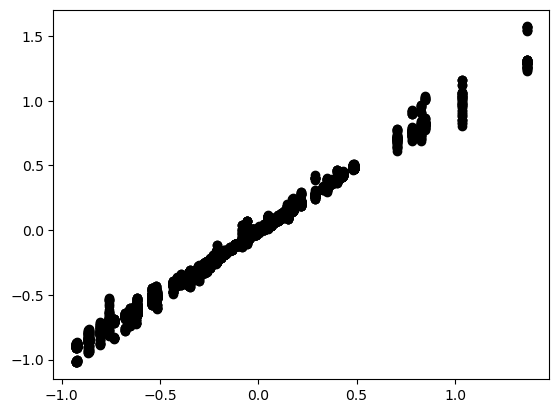

In [26]:
from sklearn.metrics import mean_squared_error

#Step 0: fix column names
pivot_df.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df.columns]
pivot_df_wall_time.columns = [col.replace('-ddx-4 COSMO', '') if 'COSMO' in col else col for col in pivot_df_wall_time.columns]
pivot_df = pivot_df[pivot_df.molecule != 'CC(=O)O']
pivot_df = pivot_df[pivot_df.molecule != 'B(O)(O)OCC']

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
# columns_to_plot = [col for col in pivot_df.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
columns_to_plot = list(pivot_df.columns)
columns_to_plot.remove('molecule')
columns_to_plot.append('HF-6-31G*')
remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    print(item)
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

print(columns_to_plot)
# The target column for comparison
target_column = 'ccsd-aug-cc-pVTZP'

rmses = []
# df_rmse = pd.DataFrame(['spec','rmse'])
# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
molecule_rmses = []
for col in columns_to_plot:
    clean_df = pivot_df[[target_column, col, 'molecule']].dropna()
    pivot_df_filter = pivot_df.filter(items = [target_column, col])
    pivot_df_wall_time_filter = pivot_df_wall_time.filter(items = [col])
    col_x = target_column
    x_tot = []
    y_tot = []
    w_time_tot = []
    for (index, row), (index_wt, row_wt) in zip(pivot_df_filter.iterrows(), pivot_df_wall_time_filter.iterrows()):
        x_values = row[col_x]
        if isinstance(x_values, np.ndarray):
                x_values = x_values.tolist()
                y_values = row[col]
                x_tot.extend(x_values)
                y_tot.extend(y_values)
                if 'ccsd' not in col:
                  w_time_tot.append(row_wt[col])
                # Check if y_values is a list and has the same length as x_values
                if isinstance(y_values, list) and len(x_values) == len(y_values):
                    plt.scatter(x_values, y_values, color='black')  # Use the color assigned to this column
                    rmse_molecule = np.sqrt(mean_squared_error(y_values, x_values))
                    information_molecule = {"molecule":clean_df['molecule'][index],
                                # "spec": spec,
                                "rmse": rmse_molecule
                                }
                    molecule_rmses.append(information_molecule)
    # print(len(x_tot))
    if len(x_tot) == 0:
         continue
    rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    wall_tm_mean = np.mean(w_time_tot)
    information = {"rmse": rmse,
                   "spec": col,
                   "wall time": wall_tm_mean}
    

    rmses.append(information)

    # plt.title(f'{col} vs. {target_column} (RMSE = {rmse:.2e} e)')        
    # plt.xlabel(target_column)
    # plt.ylabel(col)
    # # Plotting details
    # plt.grid(True)  # Optional: Add a grid for better readability
    # plt.show()
df_dft_rmse = pd.DataFrame(rmses)
df_molecules_rmse  = pd.DataFrame(molecule_rmses)



In [27]:
df_molecules_rmse

,molecule,rmse
0,Brc1cc[nH]c1,0.017208
1,C1CCNC1,0.007926
2,CC(=O)[O-],0.079652
3,CC(C)=O,0.009697
4,CC(C)F,0.006805
...,...,...
640,Clc1cccnc1,0.026550
641,Fc1ccccc1,0.020837
642,O=C1CCCN1,0.051314
643,[O-]c1ccsn1,0.050986


In [43]:
df_rmse

,rmse,spec,wall time,method,basis
0,0.024746,B3LYP-6-311G*,33.540418,B3LYP,6-311G*
1,0.040129,B3LYP-6-31G*,29.857625,B3LYP,6-31G*
2,0.019622,B3LYP-def2-svpd,40.446782,B3LYP,def2-svpd
3,0.015203,B3LYP-def2-tzvp,45.013661,B3LYP,def2-tzvp
4,0.012786,B3LYP-def2-tzvpd,62.880849,B3LYP,def2-tzvpd
5,0.016687,B3LYP-def2-tzvpp,52.087572,B3LYP,def2-tzvpp
6,0.012946,B3LYP-def2-tzvppd,64.872968,B3LYP,def2-tzvppd
7,0.043635,HF-6-311G*,24.447560,HF,6-311G*
8,0.051900,HF-6-31G*,23.158160,HF,6-31G*
9,0.054746,HF-def2-svpd,25.510162,HF,def2-svpd


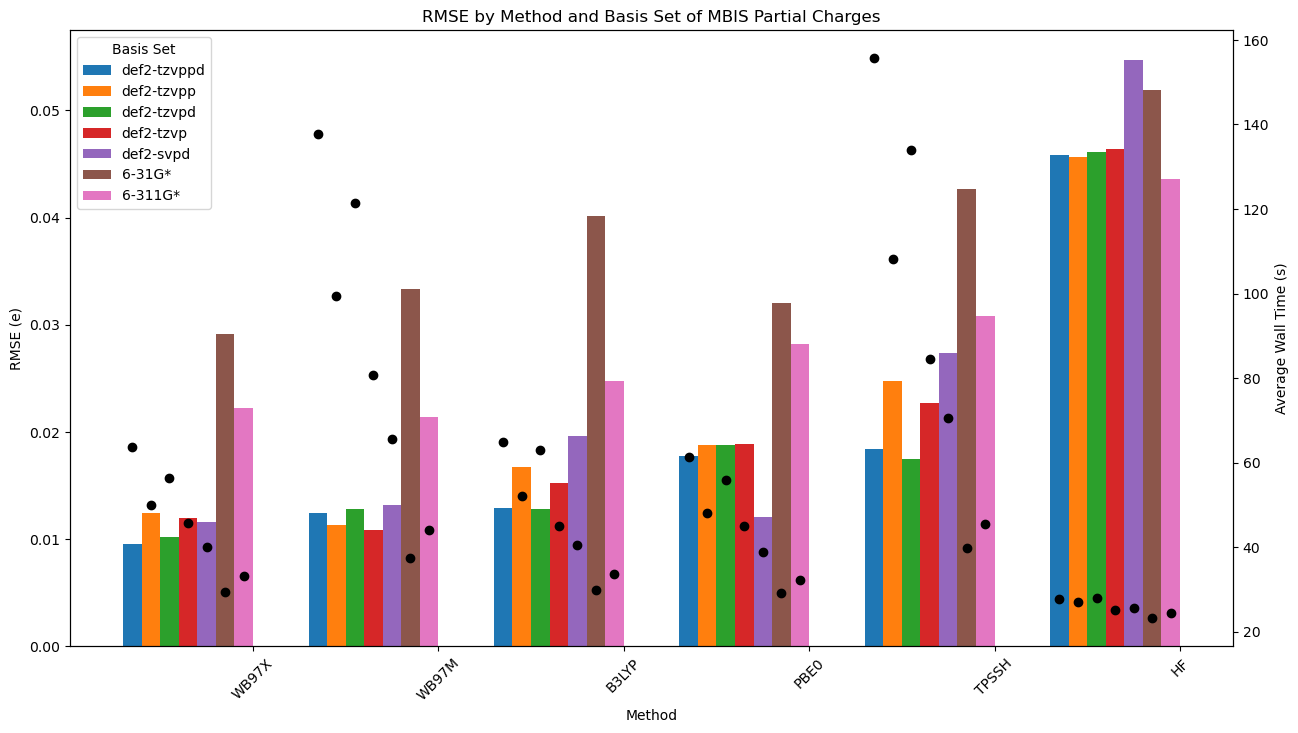

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define your desired order for the basis sets
desired_order = [
    'def2-tzvppd', 'def2-tzvpp', 'def2-tzvpd', 'def2-tzvp', 'def2-svpd',
    '6-31G*', '6-311G*'
]

# Assume df_dft_rmse is your original DataFrame (make a copy for safety)
df_rmse = df_dft_rmse.copy()

# Extract 'method' and 'basis' from the 'spec' column
df_rmse['method'] = df_rmse['spec'].apply(lambda x: x.split('-')[0].upper())
df_rmse['basis'] = df_rmse['spec'].apply(lambda x: '-'.join(x.split('-')[-2:]))

# Optional: limit the DataFrame to only rows that have basis sets in your desired order
df_rmse = df_rmse[df_rmse['basis'].isin(desired_order)]

# Cast the 'basis' column as a categorical with your desired order
df_rmse['basis'] = pd.Categorical(df_rmse['basis'], categories=desired_order, ordered=True)

# (Keep the filter on RMSE as desired; note that in your sample, RMSE values are low so you might want "< 0.12")
df_rmse = df_rmse[df_rmse['rmse'] < 0.12]

# Calculate average RMSE by method to determine ordering of the methods
average_rmse_by_method = df_rmse.groupby('method')['rmse'].mean().sort_values()

# Sort the DataFrame by average RMSE, then method and basis
df_rmse['method_avg_rmse'] = df_rmse['method'].map(average_rmse_by_method)
df_rmse_sorted = df_rmse.sort_values(by=['method_avg_rmse', 'method', 'basis'])
df_rmse_sorted = df_rmse_sorted.drop(columns=['method_avg_rmse'])

# Ensure that the method column is a categorical with the proper ordering
df_rmse_sorted['method'] = pd.Categorical(
    df_rmse_sorted['method'],
    categories=average_rmse_by_method.index,
    ordered=True
)

# Create the pivot tables for RMSE and wall time
pivot_table = df_rmse_sorted.pivot_table(
    index='method',
    columns='basis',
    values='rmse',
    aggfunc='mean'
)
pivot_table_wall = df_rmse_sorted.pivot_table(
    index='method',
    columns='basis',
    values='wall time',
    aggfunc='mean'
)

# Remove the CCSD row from both pivot tables (if present)
pivot_table_plot = pivot_table.drop(index='CCSD', errors='ignore')
pivot_table_wall_plot = pivot_table_wall.drop(index='CCSD', errors='ignore')

# Drop any columns that are entirely NaN (e.g., those that might come only from CCSD)
pivot_table_plot = pivot_table_plot.dropna(axis=1, how='all')
pivot_table_wall_plot = pivot_table_wall_plot.dropna(axis=1, how='all')

# Re-index the pivot table columns to follow the desired order.
# (This will keep only those basis sets that are present in the data.)
pivot_table_plot = pivot_table_plot.reindex(columns=desired_order)
pivot_table_plot = pivot_table_plot.dropna(axis=1, how='all')
pivot_table_wall_plot = pivot_table_wall_plot.reindex(columns=desired_order)
pivot_table_wall_plot = pivot_table_wall_plot.dropna(axis=1, how='all')

# Use matplotlib's default color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Build a color mapping for each basis in the pivot table (based on the desired order)
color_map = {}
for basis in pivot_table_plot.columns:
    # Find the index in desired_order so that the color matches your specified order.
    idx = desired_order.index(basis)
    color_map[basis] = default_colors[idx % len(default_colors)]

# Now, create the plot with two y-axes (bars for RMSE and scatter for wall time)
fig, ax = plt.subplots(figsize=(15, 8))
ax2 = ax.twinx()
bar_width = 0.1

# (Optional) Calculate group width if you need it; here we compute the maximum number of non-NaN entries
counts = [np.sum(~pivot_table_plot.loc[method].isna()) for method in pivot_table_plot.index]
group_width = np.max(counts) * bar_width if counts else 0

# Loop over each basis (now in the desired order) to plot bars and scatter points
for i, basis in enumerate(pivot_table_plot.columns):
    # Compute an offset for each method based on how many basis values are present in that row
    offsets = np.array([
        bar_width * (i - np.sum(~pivot_table_plot.loc[method].isna()) / 2)
        for method in pivot_table_plot.index
    ])
    positions = np.arange(len(pivot_table_plot.index)) + offsets

    # Plot RMSE as bars using the default color assigned to this basis
    ax.bar(positions, pivot_table_plot[basis], width=bar_width, label=basis, color=color_map[basis])
    # Plot wall time as scatter points, using the same color
    ax2.scatter(positions, pivot_table_wall_plot[basis], label=basis, color='black')

# Set the x-axis tick positions and labels based on the method names
ax.set_xticks(np.arange(len(pivot_table_plot.index)) + bar_width / 2 * (len(pivot_table_plot.columns) - 1))
ax.set_xticklabels(pivot_table_plot.index, rotation=45)

# Label the axes and add a title and legend
ax.set_xlabel('Method')
ax.set_ylabel('RMSE (e)')
ax2.set_ylabel('Average Wall Time (s)')
ax.set_title('RMSE by Method and Basis Set of MBIS Partial Charges')
ax.legend(title='Basis Set')

plt.show()


In [56]:
df_prepared = df[['specification','molecule','basis','dipole','charges']]

pivot_df_dipole = df_prepared.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='dipole',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()
pivot_df_dipole

specification,molecule,B3LYP-6-311G*-ddx-4 COSMO,B3LYP-6-31G*-ddx-4 COSMO,B3LYP-def2-svpd-ddx-4 COSMO,B3LYP-def2-tzvp-ddx-4 COSMO,B3LYP-def2-tzvpd-ddx-4 COSMO,B3LYP-def2-tzvpp-ddx-4 COSMO,B3LYP-def2-tzvppd-ddx-4 COSMO,HF-6-311G*-ddx-4 COSMO,HF-6-31G*-ddx-4 COSMO,...,WB97M-D3BJ-def2-tzvpp-ddx-4 COSMO,WB97M-D3BJ-def2-tzvppd-ddx-4 COSMO,WB97X-D-6-311G*-ddx-4 COSMO,WB97X-D-6-31G*-ddx-4 COSMO,WB97X-D-def2-svpd-ddx-4 COSMO,WB97X-D-def2-tzvp-ddx-4 COSMO,WB97X-D-def2-tzvpd-ddx-4 COSMO,WB97X-D-def2-tzvpp-ddx-4 COSMO,WB97X-D-def2-tzvppd-ddx-4 COSMO,ccsd-aug-cc-pVTZP
0,Brc1cc[nH]c1,"[-1.2953943231918856, -0.5252076718872747, -0....","[-1.3118822892410549, -0.5110151770381801, -0....","[-1.2603348337478621, -0.4971843054870426, -0....","[-1.2706383862526422, -0.5051492461239029, -0....","[-1.24649691118924, -0.4906426545635796, -0.13...","[-1.261662481162631, -0.5008752368520035, -0.1...","[-1.2461721466539757, -0.4900746361492061, -0....","[-1.3886944899277864, -0.5438494968748309, -0....","[-1.3983428621718588, -0.5243996013981249, -0....",...,"[-1.2739920154524498, -0.5108837101104502, -0....","[-1.260337842416618, -0.5004050087313505, -0.1...","[-1.313044223743077, -0.5348799317732471, -0.1...","[-1.325433384466919, -0.518971197646783, -0.14...","[-1.2913230936453601, -0.5080369146707948, -0....","[-1.296100343016576, -0.5171397170871401, -0.1...","[-1.271358677022647, -0.5038106483895959, -0.1...","[-1.2866187386722174, -0.5117436542837766, -0....","[-1.270006860333325, -0.5022571140716092, -0.1...","[-1.2333162800917705, -0.4930380861029402, -0...."
1,Brc1ccccc1,"[-0.7070148411128798, -0.037632012198887566, -...","[-0.7504798607498628, -0.03994425563852033, -0...","[-0.7019719494553271, -0.037361270264899105, -...","[-0.6987129182177512, -0.0371895897292962, -0....","[-0.6965723194471138, -0.037075359365035254, -...","[-0.6944060501369904, -0.03696026915674544, -0...","[-0.6968127625872853, -0.03708809158927373, -0...","[-0.8172765019907899, -0.04349179361430444, -0...","[-0.8596626760912045, -0.04574684031043752, -0...",...,"[-0.705223227594928, -0.03753125985587502, -0....","[-0.7090718255441857, -0.03773500922595119, -0...","[-0.7238867832255096, -0.038527590816094914, -...","[-0.7640135025320376, -0.04066250985915154, -0...","[-0.732919402610662, -0.0390041489275017, -0.0...","[-0.7204711400198107, -0.03834256835436811, -0...","[-0.7150087787327948, -0.03805095469581943, -0...","[-0.7173478152137136, -0.03817617527982087, -0...","[-0.7156239288629251, -0.0380836004278482, -0....",NaN
2,C1CCNC1,"[-0.05340733622930216, 0.07182754499833566, 0....","[-0.040306160275938474, 0.05983945598220153, 0...","[-0.03508005739546949, 0.056428395755045546, 0...","[-0.03906031082588246, 0.058699069660290704, 0...","[-0.03219053856960663, 0.05356931587712177, 0....","[-0.03849316642676026, 0.057787212422743206, 0...","[-0.032267689292735824, 0.05361065450987068, 0...","[-0.03622914786590847, 0.060269069645700224, 0...","[-0.023416313261286348, 0.04944599764160662, 0...",...,"[-0.03768384362811794, 0.05807079435683127, 0....","[-0.03208273488453983, 0.05450675795946358, 0....","[-0.04850822903431773, 0.06908904968048724, 0....","[-0.034715001411026236, 0.05666578367788455, 0...","[-0.03050763573996562, 0.053861670084889735, 0...","[-0.03754108083918162, 0.05882203199288005, 0....","[-0.03208415238814499, 0.0547786966800925, 0.3...","[-0.0355803450061245, 0.05665928398685738, 0.3...","[-0.031276171104672734, 0.05406370288403339, 0...","[-0.026712145542145294, 0.05056951378575869, 0..."
3,C1CCOC1,"[-0.5432887901474004, 0.3476876857324278, -0.1...","[-0.5354847203230602, 0.3426869544644493, -0.1...","[-0.5656917949597151, 0.36203375817628647, -0....","[-0.5413539051448968, 0.3464536559728657, -0.1...","[-0.5470675531582252, 0.35011504926654524, -0....","[-0.5378627330490886, 0.34422068017565977, -0....","[-0.5468231945293454, 0.3499589508983316, -0.1...","[-0.6050645442135583, 0.38722348449260124, -0....","[-0.6089516191497442, 0.38970623134099647, -

In [57]:
df_rmse

,rmse,spec,wall time,method,basis,method_avg_rmse
0,0.024746,B3LYP-6-311G*,33.540418,B3LYP,6-311G*,0.020303
1,0.040129,B3LYP-6-31G*,29.857625,B3LYP,6-31G*,0.020303
2,0.019622,B3LYP-def2-svpd,40.446782,B3LYP,def2-svpd,0.020303
3,0.015203,B3LYP-def2-tzvp,45.013661,B3LYP,def2-tzvp,0.020303
4,0.012786,B3LYP-def2-tzvpd,62.880849,B3LYP,def2-tzvpd,0.020303
5,0.016687,B3LYP-def2-tzvpp,52.087572,B3LYP,def2-tzvpp,0.020303
6,0.012946,B3LYP-def2-tzvppd,64.872968,B3LYP,def2-tzvppd,0.020303
7,0.043635,HF-6-311G*,24.447560,HF,6-311G*,0.048278
8,0.051900,HF-6-31G*,23.158160,HF,6-31G*,0.048278
9,0.054746,HF-def2-svpd,25.510162,HF,def2-svpd,0.048278


In [58]:
pivot_df_dipole['molecule'].unique()

array(['Brc1cc[nH]c1', 'Brc1ccccc1', 'C1CCNC1', 'C1CCOC1',
       'C1CC[NH2+]CC1', 'CC', 'CC(=O)O', 'CC(=O)[O-]', 'CC(C)=O',
       'CC(C)F', 'CCO', 'CCOB(O)O', 'CCS', 'CCSC', 'COC', 'COCC(F)(F)F',
       'COC[B-](F)(F)F', 'CO[Si](C)(C)O', 'CS(=O)(=O)[O-]',
       'C[Si]1(C)CCCC1', 'Cc1c[nH]c2ccccc12', 'Clc1ccccc1', 'Clc1cccnc1',
       'Fc1cccc(F)c1F', 'Fc1ccccc1', 'N#Cc1ccccc1', 'Nc1ccccc1',
       'O=C1CCCN1', 'Oc1ccccc1', '[O-]c1ccsn1', '[S-]c1ccccc1',
       'c1c[nH+]c[nH]1', 'c1ccccc1', 'c1ccsc1'], dtype=object)

In [59]:
esp_db = MoleculePropStore('/mnt/storage/nobackup/nca121/paper_charge_comparisons/async_chargecraft_more_workers/benchmark_wf_analysis/QCArchive_review/benchmark_review/benchmark.db')



In [60]:
esp_db.retrieve(smiles='CCO')

[MoleculePropRecord(tagged_smiles='[C:1]([C:2]([O:3][H:9])([H:7])[H:8])([H:4])([H:5])[H:6]', conformer=array([[-0.9186198 ,  0.06840562,  0.0601357 ],
        [ 0.50832554, -0.41589639, -0.13645246],
        [ 1.44631976,  0.39778409,  0.51543623],
        [-1.06010443,  1.05642133, -0.37116226],
        [-1.62616598, -0.60309467, -0.41671228],
        [-1.15700232,  0.12715035,  1.116056  ],
        [ 0.73901195, -0.48796336, -1.19789946],
        [ 0.63178215, -1.40345774,  0.28728931],
        [ 1.43645313,  1.26065078,  0.14330923]]), grid_coordinates=array([[-4.24264069e+00, -3.53553391e-01,  1.23358114e-17],
        [-4.24264069e+00,  0.00000000e+00, -3.53553391e-01],
        [-4.24264069e+00,  0.00000000e+00,  3.53553391e-01],
        ...,
        [ 4.24264069e+00,  1.06066017e+00,  1.41421356e+00],
        [ 4.24264069e+00,  1.41421356e+00,  3.53553391e-01],
        [ 4.24264069e+00,  1.41421356e+00,  1.06066017e+00]]), esp=array([[ 0.00218062],
        [ 0.0023167 ],
        [

In [81]:
esp_db  =MoleculePropStore('/mnt/storage/nobackup/nca121/paper_charge_comparisons/async_chargecraft_more_workers/benchmark_wf_analysis/QCArchive_review/benchmark_review/benchmark_NEW.db')
smiles_list = pivot_df_dipole['molecule'].unique()
df_rmse
# Some methods won't be indexed if we don't change them
df_rmse['method'] = df_rmse['method'].replace({
    'WB97M': 'wb97x-d',
    'WB97X': 'wb97m-d3bj'
})

add_data = []
for mol in smiles_list:
    for row in df_rmse[['method','basis']].iterrows():
        method = row[1]['method']
        basis = row[1]['basis']
        try:
            item =  esp_db.retrieve(smiles=mol,method=method.lower(),basis=basis.lower(), implicit_solvent=None)
            record_data = {
                    "specification": f'gas-{method}-{basis}',
                    "molecule": mol,
                    "basis":basis ,
                    "conformer_geom": item[0].conformer,
                    "dipole": item[0].dipole,
                    "charges": item[0].mbis_charges.flatten(),
                    "mbis dipoles": item[0].mbis_dipole.flatten(),
                    "mbis quadrupoles": item[0].mbis_quadropole.flatten(),
                    "esp": item[0].esp_quantity,
                    "grid": item[0].grid_coordinates_quantity,
                }
            add_data.append(record_data)
        except IndexError:
            continue
df_esps = pd.DataFrame(add_data)

df_esp_all = pd.concat([df_esps,df_ccsd], axis=0)
df_esp_all

,specification,molecule,basis,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,esp,grid,tagged_smiles
0,gas-B3LYP-6-311G*,Brc1cc[nH]c1,6-311G*,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2953943231918856, -0.5252076718872747, -0....","[-0.2718169739839899, -0.06638200574420736, -0...","[0.0393256200884422, 0.005172077405088979, 0.0...","[-4.826119708686556, 0.012423878459025175, -0....",[0.023377867879353587 hartree / elementary_cha...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
1,gas-B3LYP-6-31G*,Brc1cc[nH]c1,6-31G*,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.3118822892410549, -0.5110151770381801, -0....","[-0.2482689641540761, -0.034626250125769045, -...","[0.04500788712881645, 0.019624020471631483, 0....","[-4.713857539617136, 0.010902237659234053, -0....",[0.02285397659207774 hartree / elementary_char...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
2,gas-B3LYP-def2-svpd,Brc1cc[nH]c1,def2-svpd,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2603348337478621, -0.4971843054870426, -0....","[-0.24992836436246707, -0.03223570473243371, -...","[0.04354087826444401, 0.006420654144094134, 0....","[-4.813906891246667, 0.018542760972589698, -0....",[0.021843365447253522 hartree / elementary_cha...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
3,gas-B3LYP-def2-tzvp,Brc1cc[nH]c1,def2-tzvp,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.2706383862526422, -0.5051492461239029, -0....","[-0.26136243513826357, -0.060489552455425956, ...","[0.04074302739806772, -0.0001389173437196886, ...","[-4.8291691615798245, 0.013348531234931628, -0...",[0.022419127222493236 hartree / elementary_cha...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
4,gas-B3LYP-def2-tzvpd,Brc1cc[nH]c1,def2-tzvpd,"[[0.17881521305000173, 1.1519877978067603, 0.2...","[-1.24649691118924, -0.4906426545635796, -0.13...","[-0.2578522365806676, -0.057113602714217934, -...","[0.03986754055610189, -0.004272962030433441, 0...","[-4.824186247448815, 0.01531323519082067, -0.0...",[0.02172623772435606 hartree / elementary_char...,"[[-4.242640687119285 angstrom, -0.353553390064...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
11,ccsd-aug-cc-pVTZP,COC,aug-cc-pVTZP,"[[1.1289908789555647, -0.3010434909209451, -0....","[-0.13556443243616334, -0.4193059677989641, 0....","[-0.057086798919978914, -0.3446153491838415, -...","[-0.10718225553533764, 0.11808736020431847, -0...","[-4.495419003176553, -0.04309044879550526, 0.0...","[[0.004148395 hartree / elementary_charge], [0...","[[-4.242640685943341 angstrom, -0.707106781774...",[C:1]([O:2][C:3]([H:7])([H:8])[H:9])([H:4])([H...
12,ccsd-aug-cc-pVTZP,COCC(F)(F)F,aug-cc-pVTZP,"[[1.645363531851785, -0.5731605712105475, 0.18...","[0.5210875760898119, -0.509948642910512, -0.55...","[-0.08246256631524243, -0.30194813544771487, -...","[-0.08358812836680773, 0.1334838740622507, -0....","[-4.519742088568253, -0.05655814536672755, 0.0...","[[-0.0066054939 hartree / elementary_charge], ...","[[-5.303300859340083 angstrom, -0.707106781186...",[C:1]([O:2][C:3]([C:4]([F:5])([F:6])[F:7])([H:...
13,ccsd-aug-cc-pVTZP,Fc1ccccc1,aug-cc-pVTZP,"[[-1.405959963037374, -0.1304423584634894, 0.0...","[-0.5526169030549752, -0.051250430602936436, 0...","[-0.19055921117170935, -0.06946168508050639, -...","[0.025923546052146734, 0.0023551662273127113, ...","[-4.713605206975114, 0.012047368575809386, 0.0...","[[0.0094097829 hartree / elementary_charge], [...","[[-4.596194077712554 angstrom, -1.060660172220...",[c:1]1([H:8])[c:2]([H:9])[c:3]([H:10])[c:4]([F...
14,ccsd-aug-cc-pVTZP,O=C1CCCN1,aug-cc-pVTZP,"[[-0.9825533935644408, -0.41076041732954965, -...","[-1.552739026098969, 0.2833932022975336, 0.293...","[-0.22135903403903173, -0.41109191442309084, 0...","[0.07037059104418489, -0.01376679818362784, 0....","[-4.730091529269204, 0.012903354565436887, -0....","[[0.0108759925 hartree / elementary_charge], [...","[[-4.24264068752634 angstrom, -1.0606601721868...",[C:1]1([H:7])(

In [62]:
df_esp_all[df_esp_all['basis'] == 'def2-tzvppd']

,specification,molecule,basis,conformer_geom,dipole,charges,mbis dipoles,mbis quadrupoles,esp,grid,tagged_smiles
16,gas-wb97m-d3bj-def2-tzvppd,Brc1cc[nH]c1,def2-tzvppd,"[[1.077697870323441, 0.14789388068382797, 0.08...","[-1.2166741575906315, -0.5985754873558093, -0....","[0.01693012025687637, -0.08372005961386939, -0...","[0.058258922581290326, 0.05342922216771192, 0....","[-4.414936619943325, 0.0068119320127034595, -0...",[[0.02200857188537597 hartree / elementary_cha...,"[[-4.242640686590107 angstrom, -0.707106781186...",NaN
34,gas-wb97m-d3bj-def2-tzvppd,Brc1ccccc1,def2-tzvppd,"[[1.165651620781975, -0.5763506604522914, -0.0...","[-0.6475763709346438, 0.3201862935743094, 0.04...","[0.08817600880157896, -0.15235216142868102, -0...","[0.029886455569430603, -0.014774816321188168, ...","[-4.2703343689368625, -0.05570068969620622, 0....",[[0.0101493184059267 hartree / elementary_char...,"[[-4.596194077712559 angstrom, -0.707106780745...",NaN
52,gas-wb97m-d3bj-def2-tzvppd,C1CCNC1,def2-tzvppd,"[[0.7006188530439237, 0.9424067047577948, -0.1...","[0.45831853708906856, 0.06769852935472276, -0....","[-0.2596220402543038, 0.030098819038522986, -0...","[-0.018884906304774043, -0.07219825833173611, ...","[-4.853444413795987, 0.0030873590652443677, 0....",[[-0.02078589034253575 hartree / elementary_ch...,"[[-4.242640687119285 angstrom, -1.060660171779...",NaN
70,gas-wb97m-d3bj-def2-tzvppd,C1CCOC1,def2-tzvppd,"[[0.7137379234091891, -0.7384810326834739, 0.3...","[-0.026270688301502698, -0.6832302098990723, 0...","[-0.2925322017181647, -0.28985132412697995, 0....","[-0.0613032906443356, 0.018215277042929957, -0...","[-4.875896284828299, -0.005817959129301157, -0...",[[0.0038500359862476685 hartree / elementary_c...,"[[-4.242640687119285 angstrom, -0.353553390186...",NaN
88,gas-wb97m-d3bj-def2-tzvppd,C1CC[NH2+]CC1,def2-tzvppd,"[[1.0808816068033518, 0.8589735935012551, 0.38...","[-0.2163228112659965, 1.4779389093012316, -0.2...","[-0.05285896952366329, -0.2819250437566377, -0...","[-0.08157470268839875, -0.0418254275104869, -0...","[-4.241091884350295, -0.003858741270365445, 0....",[[0.11550555814834684 hartree / elementary_cha...,"[[-4.596194078006546 angstrom, -0.353553390887...",NaN
106,gas-wb97m-d3bj-def2-tzvppd,CC,def2-tzvppd,"[[-0.7628641744518134, 0.007212325544117799, -...","[-2.6951905152117206e-09, -6.2313282089832e-08...","[-0.3605755795681534, -0.3605755807653497, 0.1...","[0.10358132078562388, -0.0009748337649452464, ...","[-5.083087408780852, 0.0011028764427313403, -0...",[[-0.0011834980957519114 hartree / elementary_...,"[[-3.889087296526011 angstrom, -1.060660171779...",NaN
124,gas-wb97m-d3bj-def2-tzvppd,CC(=O)O,def2-tzvppd,"[[-0.9552138092819159, -0.09210191769708893, 0...","[-0.2002687430531367, -0.4890511754404958, 0.4...","[-0.6699802493948525, 0.9178897391507849, -0.6...","[-0.022889853854315807, -0.00531678078890161, ...","[-5.489298829095372, -0.016905396743464956, 0....",[[0.007243854325221122 hartree / elementary_ch...,"[[-4.242640687119285 angstrom, -0.707106781848...",NaN
142,gas-wb97m-d3bj-def2-tzvppd,CC(=O)[O-],def2-tzvppd,"[[-0.6266242364811933, -0.11501855595262243, -...","[-2.59341838782057, -0.4350883313591636, -0.62...","[-0.8058680849236083, 1.0571073703913352, -0.8...","[0.0263231478992638, -0.0052101208982953656, 0...","[-6.379526951562935, -0.014931602784065799, -0...",[[-0.0997976311628288 hartree / elementary_cha...,"[[-3.8890872957700435 angstrom, -1.06066017177...",NaN
160,gas-wb97m-d3bj-def2-tzvppd,CC(C)=O,def2-tzvppd,"[[-1.2888043977731471, 0.1379139689102266, 0.0...","[-0.044054948332870936, 0.8869412951714821, 0....","[-0.6424917489786451, 0.7237468090869638, -0.6...","[-0.006759355687183255, -0.0008920572194911271...","[-5.5003206659507375, 0.022217466410010323, -0...",[[0.00429422874579366 hartree / elementary_cha...,"[[-4.596194077712559 angstrom, -0.353553390064...",NaN
178,gas-wb97m-d3bj-def2-tzvppd,CC(C)F,def2-tzvppd,"[[1.2590731847322996, 0.27495066254844447, -0....","[0.016181902533255244, 0

In [63]:
df_prepared_esp = df_esp_all[['specification','molecule','basis','dipole','charges','esp']]

pivot_df_esp = df_prepared_esp.pivot_table(index=['molecule'], 
                                   columns='specification', 
                                   values='esp',
                                   aggfunc=lambda x: x.iloc[0] if not x.empty else None).reset_index()
pivot_df_esp

specification,molecule,ccsd-aug-cc-pVTZP,gas-B3LYP-6-31G*,gas-B3LYP-def2-svpd,gas-B3LYP-def2-tzvpp,gas-HF-6-31G*,gas-PBE0-6-31G*,gas-PBE0-def2-svpd,gas-PBE0-def2-tzvpp,gas-TPSSH-6-31G*,gas-TPSSH-def2-svpd,gas-TPSSH-def2-tzvpp,gas-wb97m-d3bj-6-31G*,gas-wb97m-d3bj-def2-svpd,gas-wb97m-d3bj-def2-tzvpp,gas-wb97m-d3bj-def2-tzvppd,gas-wb97x-d-6-31G*,gas-wb97x-d-def2-svpd,gas-wb97x-d-def2-tzvpp
0,Brc1cc[nH]c1,"[[0.022713849 hartree / elementary_charge], [0...",[[0.022675442913332233 hartree / elementary_ch...,[[0.021718779482232442 hartree / elementary_ch...,[[0.022026481295251976 hartree / elementary_ch...,[[0.02392234008864147 hartree / elementary_cha...,[[0.023217205737506852 hartree / elementary_ch...,[[0.022298761919262056 hartree / elementary_ch...,[[0.022439137416987442 hartree / elementary_ch...,[[0.023070820778530177 hartree / elementary_ch...,[[0.022170515762749865 hartree / elementary_ch...,[[0.022259820753204984 hartree / elementary_ch...,[[0.022994853391391068 hartree / elementary_ch...,[[0.022217573246392952 hartree / elementary_ch...,[[0.022350413231179367 hartree / elementary_ch...,[[0.02200857188537597 hartree / elementary_cha...,[[0.02318365120463195 hartree / elementary_cha...,[[0.022417129713034 hartree / elementary_charg...,[[0.022504575370761337 hartree / elementary_ch...
1,Brc1ccccc1,NaN,[[0.010161834803595227 hartree / elementary_ch...,[[0.009795656565413147 hartree / elementary_ch...,[[0.009910412628457266 hartree / elementary_ch...,[[0.011738053369339418 hartree / elementary_ch...,[[0.010755111691175934 hartree / elementary_ch...,[[0.01028254279194396 hartree / elementary_cha...,[[0.010276963677511297 hartree / elementary_ch...,[[0.01054313044898425 hartree / elementary_cha...,[[0.01007763761718028 hartree / elementary_cha...,[[0.010047140577004399 hartree / elementary_ch...,[[0.01050090683795979 hartree / elementary_cha...,[[0.010211917115148239 hartree / elementary_ch...,[[0.010179680924585988 hartree / elementary_ch...,[[0.0101493184059267 hartree / elementary_char...,[[0.01073189638104921 hartree / elementary_cha...,[[0.010445995625027571 hartree / elementary_ch...,[[0.010334054181552865 hartree / elementary_ch...
2,C1CCNC1,"[[0.0017020617 hartree / elementary_charge], [...",[[-0.01891084942726895 hartree / elementary_ch...,[[-0.020277053634287334 hartree / elementary_c...,[[-0.019518843287266385 hartree / elementary_c...,[[-0.021633946530155157 hartree / elementary_c...,[[-0.019557976602933458 hartree / elementary_c...,[[-0.020082068827640853 hartree / elementary_c...,[[-0.01948088393305536 hartree / elementary_ch...,[[-0.019146686863822815 hartree / elementary_c...,[[-0.01977004161392415 hartree / elementary_ch...,[[-0.01918440934018495 hartree / elementary_ch...,[[-0.019505082788270123 hartree / elementary_c...,[[-0.020541990460716697 hartree / elementary_c...,[[-0.01981601226570806 hartree / elementary_ch...,[[-0.02078589034253575 hartree / elementary_ch...,[[-0.019964903706530812 hartree / elementary_c...,[[-0.020810263799989848 hartree / elementary_c...,[[-0.020088027920823315 hartree / elementary_c...
3,C1CCOC1,NaN,[[0.004179803696575668 hartree / elementary_ch...,[[0.004087623255712991 hartree / elementary_ch...,[[0.003906728159379647 hartree / elementary_ch...,[[0.00518534586451036 hartree / elementary_cha...,[[0.004173601347625677 hartree / elementary_ch...,[[0.003953943386201253 hartree / elementary_ch...,[[0.00372158523327748 hartree / elementary_cha...,[[0.0042292497232132575 hartree / elementary_c...,[[0.004048985720142895 hartree / elementary_ch...,[[0.0037932683111225884 hartree / elementary_c...,[[0.004289552117331397 hartree / elementary_ch...,[[0.0041626376062069426 hartree / elementary_c...,[[0.003916291656534732 hartree / elementary_ch...,[[0.0038500359862476685 hartree / elementary_c...,[[0.004320353746299688 hartree / elementary_ch...,[[0.00410890260570973 hartree / elementary_cha...,[[0.0038725159413210974 hartree / elementary_c...
4,C1CC[NH2+]CC1,NaN,[[0.1152395020071797 hartree /

In [68]:
pivot_df_esp.to_csv('esp_csv.csv')

In [84]:
pivot_df_esp[pivot_df_esp['molecule'] == 'c1ccsc1']


specification,molecule,ccsd-aug-cc-pVTZP,gas-B3LYP-6-31G*,gas-B3LYP-def2-svpd,gas-B3LYP-def2-tzvpp,gas-HF-6-31G*,gas-PBE0-6-31G*,gas-PBE0-def2-svpd,gas-PBE0-def2-tzvpp,gas-TPSSH-6-31G*,gas-TPSSH-def2-svpd,gas-TPSSH-def2-tzvpp,gas-wb97m-d3bj-6-31G*,gas-wb97m-d3bj-def2-svpd,gas-wb97m-d3bj-def2-tzvpp,gas-wb97m-d3bj-def2-tzvppd,gas-wb97x-d-6-31G*,gas-wb97x-d-def2-svpd,gas-wb97x-d-def2-tzvpp
33,c1ccsc1,NaN,[[0.008046978483130296 hartree / elementary_ch...,[[0.008132649192999608 hartree / elementary_ch...,[[0.00818265039221 hartree / elementary_charge...,[[0.009168165612437384 hartree / elementary_ch...,[[0.008661330431229075 hartree / elementary_ch...,[[0.008674624547079901 hartree / elementary_ch...,[[0.00860868639454715 hartree / elementary_cha...,[[0.00837734634540066 hartree / elementary_cha...,[[0.008418033185613183 hartree / elementary_ch...,[[0.008311423340248147 hartree / elementary_ch...,[[0.00833226150383215 hartree / elementary_cha...,[[0.008448264017330231 hartree / elementary_ch...,[[0.008411890245610287 hartree / elementary_ch...,[[0.008429218927212823 hartree / elementary_ch...,[[0.008682852188414358 hartree / elementary_ch...,[[0.008725501246597211 hartree / elementary_ch...,[[0.008617643481385606 hartree / elementary_ch...


In [78]:
from openff.units import unit

HA_TO_KCAL_P_MOL = 627.509391  # Hartrees to kilocalories per mole

# Step 1: Filter columns
# Exclude the first four columns and select only those with 'NoSolvent_nan' but not the target column itself
columns_to_plot = [col for col in pivot_df_esp.columns if 'gas' in col and col not in ['BaseExceptionGroupspecification','molecule','basis']]
# columns_to_plot.append('HF-6-31G*')
print(columns_to_plot)

remove_items = ['ccsd-gas-aug-cc-pvtz', 'dlpno-MP2-4-aug-cc-pvtz',
       'dlpno-MP2-4-cc-pvtz', 'dlpno-MP2-78.4-aug-cc-pvtz',
       'dlpno-MP2-78.4-cc-pvtz', 'dlpno-MP2-gas-aug-cc-pvtz',
       'dlpno-MP2-gas-cc-pvtz', 'mp2-gas-6-311G*','MP2-4-aug-cc-pvtz', 'MP2-4-cc-pvtz',
       'MP2-78.4-aug-cc-pvtz', 'MP2-78.4-cc-pvtz', 'MP2-gas-aug-cc-pvtz',
       'MP2-gas-cc-pvtz']

for item in remove_items:
    try:
        columns_to_plot.remove(item)
    except ValueError:
        continue

# print(columns_to_plot)
# The target column for comparison
target_column = 'ccsd-aug-cc-pVTZP'

rmses = []
# df_rmse = pd.DataFrame(['spec','rmse'])
# Step 2: Plotting
# Loop through the selected columns and plot them against the target column
#something wrong with boron results
pivot_df_esp['molecule']
molecule_rmses = []
for col in columns_to_plot:
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    clean_df = pivot_df_esp[[target_column, col, 'molecule']].dropna()
    pivot_df_filter = pivot_df_esp.filter(items = [target_column, col, 'molecule'])
    pivot_df_wall_time_filter = pivot_df_wall_time.filter(items = [col])
    col_x = target_column
    x_tot = []
    y_tot = []
    w_time_tot = []
    for (index, row), (index_wt, row_wt) in zip(pivot_df_filter.iterrows(), pivot_df_wall_time_filter.iterrows()):
        x_values = row[col_x]
        if isinstance(x_values, unit.Quantity):
                x_values = x_values.m.flatten().tolist()
                y_values = row[col].m.flatten().tolist()
                print('x vals')
                print(len(x_values))
                print('y vals')
                print(len(y_values))

                if len(x_values) != len(y_values):
                    print(f"excluding {row['molecule']} due to len")
                    print(col)
                    continue
                rmse_esp_mol = ((((np.array(x_values) - np.array(y_values))**2).mean()**0.5)*HA_TO_KCAL_P_MOL)
                if rmse_esp_mol > 10:
                     print(f"excluding {row['molecule']}")
                     continue
                # print(x_values)
                x_tot.extend(x_values)
                y_tot.extend(y_values)
    # print(len(x_tot))
    if len(x_tot) == 0:
         continue
    rmse_esp = ((((np.array(x_tot) - np.array(y_tot))**2).mean()**0.5)*HA_TO_KCAL_P_MOL)
    # rmse = np.sqrt(mean_squared_error(x_tot, y_tot))
    wall_tm_mean = np.mean(w_time_tot)
    information = {"rmse": rmse_esp,
                   "spec": col,
                   "wall time": wall_tm_mean}
    

    rmses.append(information)

df_dft_rmse_esp = pd.DataFrame(rmses)
# df_molecules_rmse_esp  = pandas.DataFrame(molecule_rmses)
df_dft_rmse_esp

['gas-B3LYP-6-31G*', 'gas-B3LYP-def2-svpd', 'gas-B3LYP-def2-tzvpp', 'gas-HF-6-31G*', 'gas-PBE0-6-31G*', 'gas-PBE0-def2-svpd', 'gas-PBE0-def2-tzvpp', 'gas-TPSSH-6-31G*', 'gas-TPSSH-def2-svpd', 'gas-TPSSH-def2-tzvpp', 'gas-wb97m-d3bj-6-31G*', 'gas-wb97m-d3bj-def2-svpd', 'gas-wb97m-d3bj-def2-tzvpp', 'gas-wb97m-d3bj-def2-tzvppd', 'gas-wb97x-d-6-31G*', 'gas-wb97x-d-def2-svpd', 'gas-wb97x-d-def2-tzvpp']
x vals
2386
y vals
2394
excluding Brc1cc[nH]c1 due to len
gas-B3LYP-6-31G*
x vals
1888
y vals
1893
excluding C1CCNC1 due to len
gas-B3LYP-6-31G*
x vals
1655
y vals
1655
x vals
1700
y vals
1654
excluding CC(=O)[O-] due to len
gas-B3LYP-6-31G*
x vals
1791
y vals
1815
excluding CC(C)=O due to len
gas-B3LYP-6-31G*
x vals
1759
y vals
1770
excluding CC(C)F due to len
gas-B3LYP-6-31G*
x vals
1564
y vals
1552
excluding CCO due to len
gas-B3LYP-6-31G*
x vals
2128
y vals
2091
excluding CCOB(O)O due to len
gas-B3LYP-6-31G*
x vals
1631
y vals
1602
excluding COC due to len
gas-B3LYP-6-31G*
x vals
2086
y v

/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/mnt/nfs/home/nca121/mambaforge/envs/openff_qc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/nfs/hom

,rmse,spec,wall time
0,6.882129,gas-B3LYP-6-31G*,NaN
1,7.093881,gas-B3LYP-def2-svpd,NaN
2,7.032261,gas-B3LYP-def2-tzvpp,NaN
3,7.289366,gas-HF-6-31G*,NaN
4,6.889574,gas-PBE0-6-31G*,NaN
5,7.060157,gas-PBE0-def2-svpd,NaN
6,7.005894,gas-PBE0-def2-tzvpp,NaN
7,6.858234,gas-TPSSH-6-31G*,NaN
8,7.021479,gas-TPSSH-def2-svpd,NaN
9,6.967551,gas-TPSSH-def2-tzvpp,NaN


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [85]:
df_dft_rmse_esp.sort_values(by='rmse')

,rmse,spec,wall time,method,basis
7,6.858234,gas-TPSSH-6-31G*,NaN,TPSSH,6-31G*
0,6.882129,gas-B3LYP-6-31G*,NaN,B3LYP,6-31G*
10,6.886069,gas-wb97m-d3bj-6-31G*,NaN,wb97m-d3bj,6-31G*
4,6.889574,gas-PBE0-6-31G*,NaN,PBE0,6-31G*
14,6.943049,gas-wb97x-d-6-31G*,NaN,wb97x-d,6-31G*
9,6.967551,gas-TPSSH-def2-tzvpp,NaN,TPSSH,def2-tzvpp
6,7.005894,gas-PBE0-def2-tzvpp,NaN,PBE0,def2-tzvpp
12,7.019761,gas-wb97m-d3bj-def2-tzvpp,NaN,wb97m-d3bj,def2-tzvpp
8,7.021479,gas-TPSSH-def2-svpd,NaN,TPSSH,def2-svpd
2,7.032261,gas-B3LYP-def2-tzvpp,NaN,B3LYP,def2-tzvpp


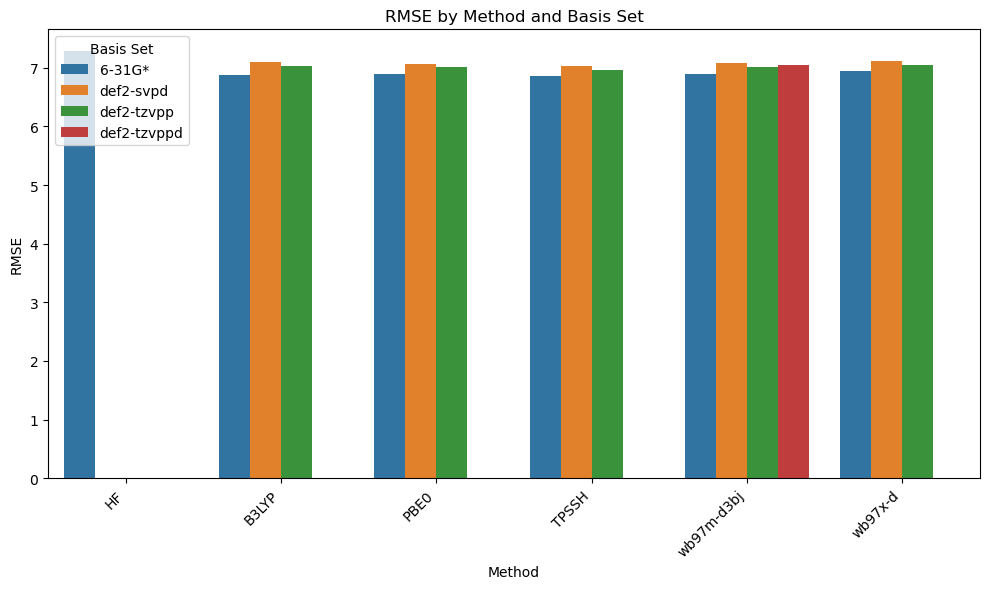

In [79]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 1) Create the sample DataFrame:
# data = [
#     {"rmse": 0.141052, "spec": "gas-wb97m-d3bj-def2-tzvppd"},
#     {"rmse": 0.242333, "spec": "gas-PBE0-def2-svpd"},
#     {"rmse": 0.260872, "spec": "gas-B3LYP-def2-svpd"},
#     {"rmse": 0.296853, "spec": "gas-wb97m-d3bj-def2-svpd"},
#     {"rmse": 0.299312, "spec": "gas-TPSSH-def2-svpd"},
#     {"rmse": 0.357396, "spec": "gas-wb97x-d-def2-svpd"},
#     {"rmse": 0.486853, "spec": "gas-wb97x-d-def2-tzvpp"},
#     {"rmse": 0.498316, "spec": "gas-wb97m-d3bj-def2-tzvpp"},
#     {"rmse": 0.555996, "spec": "gas-B3LYP-def2-tzvpp"},
#     {"rmse": 0.572233, "spec": "gas-PBE0-def2-tzvpp"},
#     {"rmse": 0.680592, "spec": "gas-TPSSH-def2-tzvpp"},
#     {"rmse": 0.962519, "spec": "gas-HF-6-31G*"},
#     {"rmse": 1.017840, "spec": "gas-wb97x-d-6-31G*"},
#     {"rmse": 1.031628, "spec": "gas-wb97m-d3bj-6-31G*"},
#     {"rmse": 1.079133, "spec": "gas-PBE0-6-31G*"},
#     {"rmse": 1.101943, "spec": "gas-B3LYP-6-31G*"},
#     {"rmse": 1.149133, "spec": "gas-TPSSH-6-31G*"},
# ]
df = df_dft_rmse_esp

# 2) Parse out the method and basis
def parse_spec(spec):
    known_bases = {"6-31G*", "def2-svpd", "def2-tzvpp", "def2-tzvppd"}
    # Remove "gas-" from the beginning
    spec_core = spec[4:]
    parts = spec_core.split('-')
    
    # Identify the basis from the end
    for i in range(1, 3):  
        # Join the last i elements
        possible_basis = '-'.join(parts[-i:])
        if possible_basis in known_bases:
            basis = possible_basis
            # The method is everything else
            method = '-'.join(parts[:-i])
            return method, basis
    return None, None

df["method"], df["basis"] = zip(*df["spec"].apply(parse_spec))

# 3) Define the orders (optional, for nicer grouping)
method_order = ["HF", "B3LYP", "PBE0", "TPSSH", "wb97m-d3bj", "wb97x-d"]
basis_order  = ["6-31G*", "def2-svpd", "def2-tzvpp", "def2-tzvppd"]

# 4) Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df, 
    x="method", 
    y="rmse", 
    hue="basis",
    order=method_order, 
    hue_order=basis_order
)
plt.title("RMSE by Method and Basis Set")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.xlabel("Method")
plt.legend(title="Basis Set")
plt.tight_layout()
plt.show()
